## Características de los archivos FITS

Los archivos FITS (Flexible Image Transport System) son el formato estándar en astronomía para almacenar y transmitir datos científicos. Algunas características clave:

- **Estructura**: Pueden contener múltiples extensiones (HDUs - Header Data Units)
- **Cabecera**: Metadatos en formato texto (clave-valor) que describen los datos
- **Datos**: Normalmente arrays multidimensionales (2D para imágenes)
- **Soporte**: Mantenido por la NASA y ampliamente usado en astronomía



=== Información DUD ===
Tamaño original: (43, 43)
Tipo de datos: >f4
Valores: min=-0.03, max=2.28

=== Información ACS ===
Tamaño: (147, 147)
Tipo de datos: >f4
Valores: min=-0.03, max=0.21

=== Después del resize ===
Nuevo tamaño DUD: (147, 147)
Valores redimensionados: min=-0.02, max=2.28


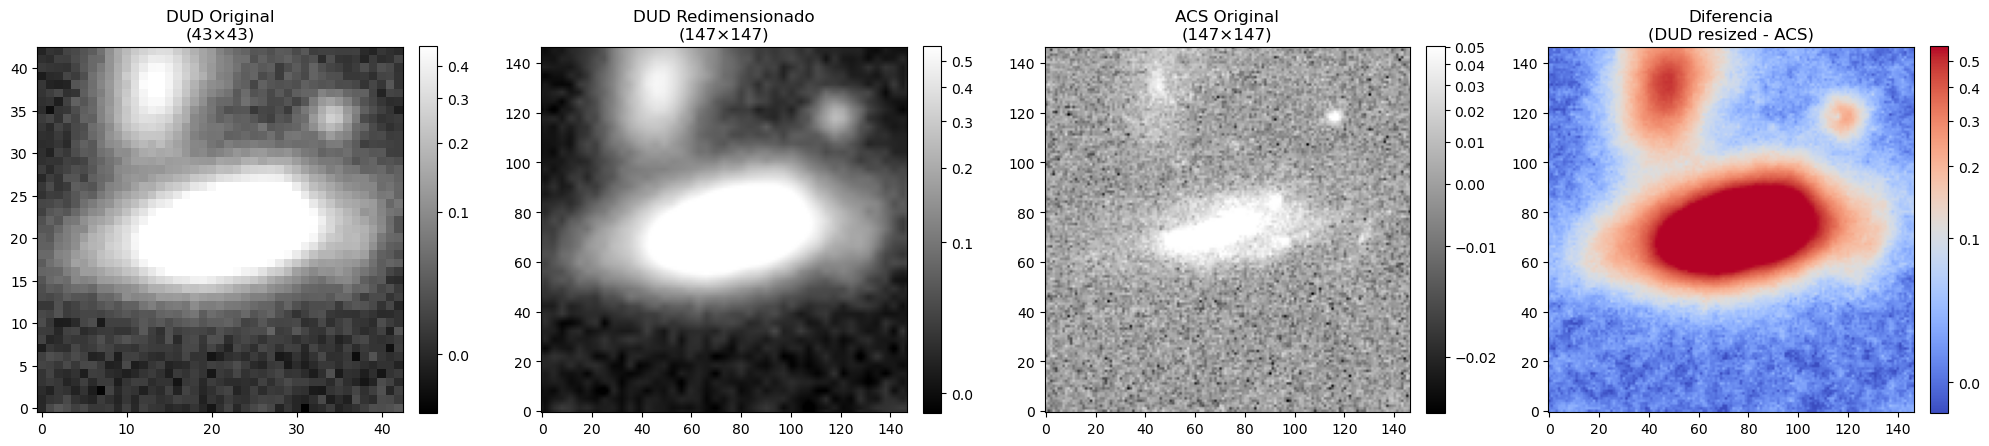

In [11]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import (ImageNormalize, AsinhStretch, ZScaleInterval)
import numpy as np
import os
from skimage.transform import resize

def load_compare_display(dud_path, acs_path):
    # Verificar que los archivos existen
    if not os.path.exists(dud_path):
        print(f"Error: El archivo DUD no existe en {dud_path}")
        return
    if not os.path.exists(acs_path):
        print(f"Error: El archivo ACS no existe en {acs_path}")
        return
    
    try:
        # Cargar los archivos FITS
        with fits.open(dud_path) as dud_hdul:
            # Obtener los datos de la primera extensión con datos válidos
            dud_data = None
            for hdu in dud_hdul:
                if hdu.data is not None and hdu.data.size > 1:  # Buscar la primera extensión con datos de imagen
                    dud_data = hdu.data
                    dud_header = hdu.header
                    break
            
            if dud_data is None:
                print("Error: No se encontraron datos válidos en el archivo DUD")
                return
            
            print("\n=== Información DUD ===")
            print(f"Tamaño original: {dud_data.shape}")
            print(f"Tipo de datos: {dud_data.dtype}")
            print(f"Valores: min={np.nanmin(dud_data):.2f}, max={np.nanmax(dud_data):.2f}")
        
        with fits.open(acs_path) as acs_hdul:
            # Obtener los datos de la primera extensión con datos válidos
            acs_data = None
            for hdu in acs_hdul:
                if hdu.data is not None and hdu.data.size > 1:  # Buscar la primera extensión con datos de imagen
                    acs_data = hdu.data
                    acs_header = hdu.header
                    break
            
            if acs_data is None:
                print("Error: No se encontraron datos válidos en el archivo ACS")
                return
            
            print("\n=== Información ACS ===")
            print(f"Tamaño: {acs_data.shape}")
            print(f"Tipo de datos: {acs_data.dtype}")
            print(f"Valores: min={np.nanmin(acs_data):.2f}, max={np.nanmax(acs_data):.2f}")
        
        # Redimensionar la imagen DUD para que coincida con ACS
        dud_resized = resize(dud_data, acs_data.shape, 
                            mode='reflect',  # Método de extrapolación
                            anti_aliasing=True,  # Aplicar anti-aliasing
                            preserve_range=True)  # Mantener el rango de valores original
        
        print("\n=== Después del resize ===")
        print(f"Nuevo tamaño DUD: {dud_resized.shape}")
        print(f"Valores redimensionados: min={np.nanmin(dud_resized):.2f}, max={np.nanmax(dud_resized):.2f}")
        
        # Configurar la visualización
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
        
        # Normalización para las imágenes
        norm_dud = ImageNormalize(dud_data, interval=ZScaleInterval(), stretch=AsinhStretch())
        norm_acs = ImageNormalize(acs_data, interval=ZScaleInterval(), stretch=AsinhStretch())
        norm_dud_resized = ImageNormalize(dud_resized, interval=ZScaleInterval(), stretch=AsinhStretch())
        
        # Mostrar imágenes originales
        im1 = ax1.imshow(dud_data, origin='lower', cmap='gray', norm=norm_dud)
        ax1.set_title('DUD Original\n(43×43)')
        plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        
        im2 = ax2.imshow(dud_resized, origin='lower', cmap='gray', norm=norm_dud_resized)
        ax2.set_title('DUD Redimensionado\n(147×147)')
        plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        
        im3 = ax3.imshow(acs_data, origin='lower', cmap='gray', norm=norm_acs)
        ax3.set_title('ACS Original\n(147×147)')
        plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
        
        # Calcular y mostrar diferencia
        diff = dud_resized - acs_data
        norm_diff = ImageNormalize(diff, interval=ZScaleInterval(), stretch=AsinhStretch())
        im4 = ax4.imshow(diff, origin='lower', cmap='coolwarm', norm=norm_diff)
        ax4.set_title('Diferencia\n(DUD resized - ACS)')
        plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
        
        plt.tight_layout()
        plt.show()
        
        return dud_resized, acs_data
    
    except Exception as e:
        print(f"\nError al procesar los archivos FITS: {str(e)}")
        return None, None

# Rutas a los archivos
dud_file = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/dud/n1/n1_0_141190.fits"
acs_file = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/acs/n1/n1_0_141190_ACS.fits"

# Ejecutar la función
dud_resized, acs_data = load_compare_display(dud_file, acs_file)

In [13]:
import os
from astropy.io import fits
import numpy as np
from tqdm import tqdm

def safe_fits_open(filepath):
    """Intenta abrir un archivo FITS de forma segura"""
    try:
        with fits.open(filepath) as hdul:
            # Verificar que contiene datos válidos
            for hdu in hdul:
                if hdu.data is not None and hdu.data.size > 1:
                    return hdul
        return None  # Archivo existe pero no tiene datos válidos
    except (OSError, IOError):
        return None  # Archivo corrupto o no existe

def analyze_datasets(base_path):
    # Definir las rutas base
    dud_base = os.path.join(base_path, "raw", "dud")
    acs_base = os.path.join(base_path, "raw", "acs")
    
    # Resultados por categoría
    results = {
        'n1': {'matches': 0, 'dud_only': 0, 'acs_only': 0, 'dud_corrupt': 0, 'acs_corrupt': 0},
        'n2': {'matches': 0, 'dud_only': 0, 'acs_only': 0, 'dud_corrupt': 0, 'acs_corrupt': 0}
    }
    
    # Estadísticas adicionales
    stats = {
        'n1': {'dud_counts': [], 'acs_counts': []},
        'n2': {'dud_counts': [], 'acs_counts': []}
    }
    
    for category in ['n1', 'n2']:
        print(f"\nProcesando categoría {category}...")
        
        # Rutas completas
        dud_path = os.path.join(dud_base, category)
        acs_path = os.path.join(acs_base, category)
        
        # Obtener listados de archivos
        try:
            dud_files = [f for f in os.listdir(dud_path) if f.endswith('.fits')]
            print(f"  - Encontrados {len(dud_files)} archivos en DUD/{category}")
        except FileNotFoundError:
            dud_files = []
            print(f"  - Advertencia: No se encontró la carpeta DUD/{category}")
        
        try:
            acs_files = [f for f in os.listdir(acs_path) if f.endswith('.fits')]
            print(f"  - Encontrados {len(acs_files)} archivos en ACS/{category}")
        except FileNotFoundError:
            acs_files = []
            print(f"  - Advertencia: No se encontró la carpeta ACS/{category}")
        
        # Convertir a conjuntos para búsqueda eficiente
        dud_set = set(dud_files)
        acs_set = set(acs_files)
        
        # Procesar archivos DUD con barra de progreso
        for dud_file in tqdm(dud_files, desc=f"Procesando DUD/{category}"):
            dud_filepath = os.path.join(dud_path, dud_file)
            dud_hdul = safe_fits_open(dud_filepath)
            
            if dud_hdul is None:
                results[category]['dud_corrupt'] += 1
                continue
                
            expected_acs_file = dud_file.replace('.fits', '_ACS.fits')
            acs_filepath = os.path.join(acs_path, expected_acs_file)
            acs_hdul = safe_fits_open(acs_filepath)
            
            if acs_hdul is None:
                results[category]['dud_only'] += 1
                continue
                
            # Tenemos una pareja válida
            results[category]['matches'] += 1
            
            # Obtener datos y calcular estadísticas
            for hdu in dud_hdul:
                if hdu.data is not None and hdu.data.size > 1:
                    stats[category]['dud_counts'].append(np.nansum(hdu.data))
                    break
            
            for hdu in acs_hdul:
                if hdu.data is not None and hdu.data.size > 1:
                    stats[category]['acs_counts'].append(np.nansum(hdu.data))
                    break
        
        # Procesar archivos ACS que no tienen pareja en DUD
        for acs_file in tqdm(acs_files, desc=f"Procesando ACS/{category}"):
            expected_dud_file = acs_file.replace('_ACS.fits', '.fits')
            if expected_dud_file not in dud_set:
                acs_filepath = os.path.join(acs_path, acs_file)
                acs_hdul = safe_fits_open(acs_filepath)
                
                if acs_hdul is None:
                    results[category]['acs_corrupt'] += 1
                else:
                    results[category]['acs_only'] += 1
    
    # Mostrar resultados detallados
    print("\n=== Resumen de correspondencia de archivos ===")
    for category in ['n1', 'n2']:
        print(f"\nCategoría {category.upper()}:")
        print(f"  - Archivos DUD analizados: {results[category]['matches'] + results[category]['dud_only'] + results[category]['dud_corrupt']}")
        print(f"  - Archivos ACS analizados: {results[category]['matches'] + results[category]['acs_only'] + results[category]['acs_corrupt']}")
        print(f"\n  - Parejas válidas encontradas: {results[category]['matches']}")
        print(f"  - Archivos DUD sin pareja: {results[category]['dud_only']}")
        print(f"  - Archivos ACS sin pareja: {results[category]['acs_only']}")
        print(f"  - Archivos DUD corruptos/vacíos: {results[category]['dud_corrupt']}")
        print(f"  - Archivos ACS corruptos/vacíos: {results[category]['acs_corrupt']}")
        
        if results[category]['matches'] > 0:
            print("\n  Estadísticas de las parejas encontradas:")
            print(f"  - Suma total de píxeles (DUD):")
            print(f"    Media: {np.mean(stats[category]['dud_counts']):.2f}")
            print(f"    Mediana: {np.median(stats[category]['dud_counts']):.2f}")
            print(f"    Mín: {np.min(stats[category]['dud_counts']):.2f}")
            print(f"    Máx: {np.max(stats[category]['dud_counts']):.2f}")
            
            print(f"\n  - Suma total de píxeles (ACS):")
            print(f"    Media: {np.mean(stats[category]['acs_counts']):.2f}")
            print(f"    Mediana: {np.median(stats[category]['acs_counts']):.2f}")
            print(f"    Mín: {np.min(stats[category]['acs_counts']):.2f}")
            print(f"    Máx: {np.max(stats[category]['acs_counts']):.2f}")
            
            # Calcular relación DUD/ACS
            ratios = np.array(stats[category]['dud_counts']) / np.array(stats[category]['acs_counts'])
            print(f"\n  - Relación DUD/ACS:")
            print(f"    Media: {np.mean(ratios):.2f}")
            print(f"    Mediana: {np.median(ratios):.2f}")
            print(f"    Mín: {np.min(ratios):.2f}")
            print(f"    Máx: {np.max(ratios):.2f}")
    
    return results, stats

# Ejecutar el análisis
base_path = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data"
results, stats = analyze_datasets(base_path)


Procesando categoría n1...
  - Encontrados 11000 archivos en DUD/n1
  - Encontrados 8475 archivos en ACS/n1


Procesando DUD/n1:   0%|                                                                     | 0/11000 [00:00<?, ?it/s]


ValueError: I/O operation on closed file

In [16]:
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

def analyze_datasets(base_path):
    # Definir las rutas base
    dud_base = os.path.join(base_path, "raw", "dud")
    acs_base = os.path.join(base_path, "raw", "acs")
    
    # Resultados por categoría
    results = {
        'n1': {'matches': 0, 'dud_only': 0, 'acs_only': 0},
        'n2': {'matches': 0, 'dud_only': 0, 'acs_only': 0}
    }
    
    # Estadísticas adicionales
    stats = {
        'n1': {'dud_counts': [], 'acs_counts': []},
        'n2': {'dud_counts': [], 'acs_counts': []}
    }
    
    for category in ['n1', 'n2']:
        # Rutas completas
        dud_path = os.path.join(dud_base, category)
        acs_path = os.path.join(acs_base, category)
        
        # Obtener listados de archivos
        try:
            dud_files = [f for f in os.listdir(dud_path) if f.endswith('.fits')]
        except FileNotFoundError:
            dud_files = []
            print(f"Advertencia: No se encontró la carpeta DUD {category}")
        
        try:
            acs_files = [f for f in os.listdir(acs_path) if f.endswith('.fits')]
        except FileNotFoundError:
            acs_files = []
            print(f"Advertencia: No se encontró la carpeta ACS {category}")
        
        # Convertir a conjuntos para búsqueda eficiente
        dud_set = set(dud_files)
        acs_set = set(acs_files)
        
        # Encontrar coincidencias
        for dud_file in dud_files:
            expected_acs_file = dud_file.replace('.fits', '_ACS.fits')
            if expected_acs_file in acs_set:
                try:
                    # Leer ambos archivos
                    dud_value = None
                    acs_value = None
                    
                    with fits.open(os.path.join(dud_path, dud_file)) as dud_hdul:
                        for hdu in dud_hdul:
                            if hdu.data is not None and hdu.data.size > 1:
                                dud_value = np.nansum(hdu.data)
                                break
            
                    with fits.open(os.path.join(acs_path, expected_acs_file)) as acs_hdul:
                        for hdu in acs_hdul:
                            if hdu.data is not None and hdu.data.size > 1:
                                acs_value = np.nansum(hdu.data)
                                break
                    
                    # Solo si ambos valores se leyeron correctamente
                    if dud_value is not None and acs_value is not None:
                        results[category]['matches'] += 1
                        stats[category]['dud_counts'].append(dud_value)
                        stats[category]['acs_counts'].append(acs_value)
                    else:
                        raise ValueError("Datos vacíos en uno de los archivos")
                
                except Exception as e:
                    print(f"Error al procesar pareja {dud_file} / {expected_acs_file} -> {e}")
                    # Contamos el que sí existe
                    if dud_value is not None:
                        results[category]['dud_only'] += 1
                    elif acs_value is not None:
                        results[category]['acs_only'] += 1
                    else:
                        # Si fallaron los dos
                        results[category]['dud_only'] += 1
                        results[category]['acs_only'] += 1
            else:
                results[category]['dud_only'] += 1
        
        # Encontrar archivos solo en ACS
        for acs_file in acs_files:
            expected_dud_file = acs_file.replace('_ACS.fits', '.fits')
            if expected_dud_file not in dud_set:
                results[category]['acs_only'] += 1
    
    # Mostrar resultados
    print("\n=== Resumen de correspondencia de archivos ===")
    for category in ['n1', 'n2']:
        print(f"\nCategoría {category.upper()}:")
        print(f"  - Parejas encontradas: {results[category]['matches']}")
        print(f"  - Archivos solo en DUD: {results[category]['dud_only']}")
        print(f"  - Archivos solo en ACS: {results[category]['acs_only']}")
        
        if results[category]['matches'] > 0:
            print("\n  Estadísticas de las parejas encontradas:")
            print(f"  - Suma total de píxeles (DUD):")
            print(f"    Media: {np.mean(stats[category]['dud_counts']):.2f}")
            print(f"    Mediana: {np.median(stats[category]['dud_counts']):.2f}")
            print(f"    Mín: {np.min(stats[category]['dud_counts']):.2f}")
            print(f"    Máx: {np.max(stats[category]['dud_counts']):.2f}")
            
            print(f"\n  - Suma total de píxeles (ACS):")
            print(f"    Media: {np.mean(stats[category]['acs_counts']):.2f}")
            print(f"    Mediana: {np.median(stats[category]['acs_counts']):.2f}")
            print(f"    Mín: {np.min(stats[category]['acs_counts']):.2f}")
            print(f"    Máx: {np.max(stats[category]['acs_counts']):.2f}")
            
            # Calcular relación DUD/ACS
            ratios = np.array(stats[category]['dud_counts']) / np.array(stats[category]['acs_counts'])
            print(f"\n  - Relación DUD/ACS:")
            print(f"    Media: {np.mean(ratios):.2f}")
            print(f"    Mediana: {np.median(ratios):.2f}")
            print(f"    Mín: {np.min(ratios):.2f}")
            print(f"    Máx: {np.max(ratios):.2f}")
    
    return results, stats

# Ejecutar el análisis
base_path = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data"
results, stats = analyze_datasets(base_path)

Error al procesar pareja n1_775_124642.fits / n1_775_124642_ACS.fits -> Empty or corrupt FITS file
Error al procesar pareja n27_110_23489.fits / n27_110_23489_ACS.fits -> Empty or corrupt FITS file

=== Resumen de correspondencia de archivos ===

Categoría N1:
  - Parejas encontradas: 8474
  - Archivos solo en DUD: 2526
  - Archivos solo en ACS: 0

  Estadísticas de las parejas encontradas:
  - Suma total de píxeles (DUD):
    Media: 203.67
    Mediana: 62.10
    Mín: 2.22
    Máx: 32165.33

  - Suma total de píxeles (ACS):
    Media: 80.22
    Mediana: 25.74
    Mín: -74.76
    Máx: 9820.26

  - Relación DUD/ACS:
    Media: inf
    Mediana: 2.42
    Mín: -11.26
    Máx: inf

Categoría N2:
  - Parejas encontradas: 7691
  - Archivos solo en DUD: 3309
  - Archivos solo en ACS: 0

  Estadísticas de las parejas encontradas:
  - Suma total de píxeles (DUD):
    Media: 188.80
    Mediana: 58.44
    Mín: 1.70
    Máx: 27268.63

  - Suma total de píxeles (ACS):
    Media: 74.83
    Mediana: 24

C:\Users\Miguel\AppData\Local\Temp\ipykernel_18380\642918917.py:117: RuntimeWarning: divide by zero encountered in divide
  ratios = np.array(stats[category]['dud_counts']) / np.array(stats[category]['acs_counts'])


In [19]:
from astropy.io import fits

print("DUD:")
with fits.open("E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/dud/n1/n1_0_141190.fits") as hdul:
    print(hdul[0].header)  # O puedes usar un for para recorrer todos los HDUs

print("\n\n\nACS:")
with fits.open("E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/acs/n1/n1_0_141190_ACS.fits") as hdul:
    print(hdul[0].header)  # O puedes usar un for para recorrer todos los HDUs

DUD:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H COMMENT DAS Cutout version 200424                                               HIERARCH variance_scale = 1.38232237686498                                      BGMEAN  =   0.0128057485766347                                                  BGVAR   =  0.00503386633462228                                                  HIERARCH EXPINFO_V = 1                                                          AR_HDU  =                    5 / HDU (1-indexed) containing the archive used to HIERARCH TRANSMISSION_CURVE_ID = 1 

Procesando archivos...


Procesando n2: 100%|████████████████████████████████████████████████████████████| 11000/11000 [00:42<00:00, 260.20it/s]



Estadísticas globales:
Valor mínimo: -7.353157043457031
Valor máximo: 366.3216857910156
Media: 0.3318800692436748
Moda aproximada (a 7 decimales): 0.012507599778473377


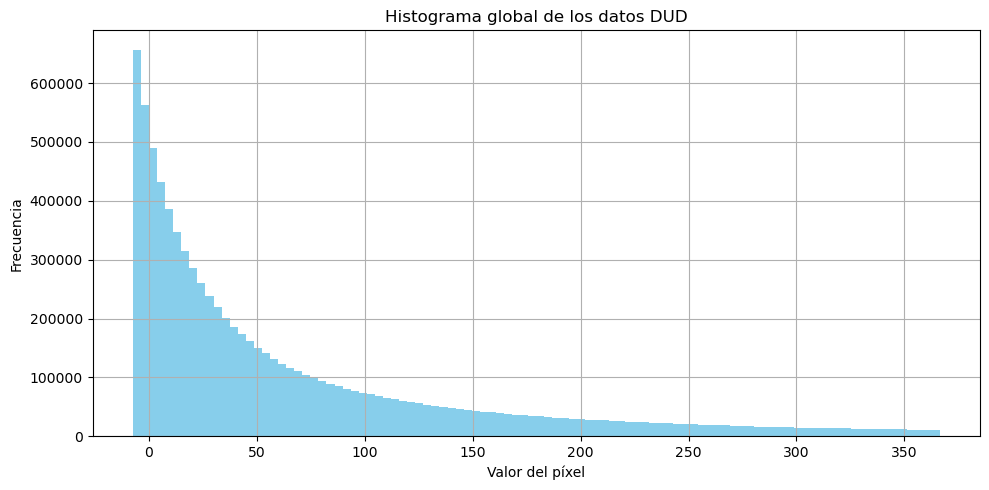

In [2]:
import os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# Ruta base
base_path = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/dud/"
subdirs = ["n1", "n2"]

# Inicializamos variables para estadísticas
min_val = np.inf
max_val = -np.inf
sum_vals = 0
count_vals = 0
hist_bins = 100  # puedes ajustar esto si hace falta
hist_range = None  # calculamos después
hist_total = None
value_counter = Counter()

# Recorremos todos los archivos
print("Procesando archivos...")
for subdir in subdirs:
    dir_path = os.path.join(base_path, subdir)
    files = [f for f in os.listdir(dir_path) if f.endswith('.fits')]

    for file in tqdm(files, desc=f"Procesando {subdir}"):
        file_path = os.path.join(dir_path, file)

        try:
            with fits.open(file_path, memmap=True) as hdul:
                for hdu in hdul:
                    if hdu.data is not None:
                        data = hdu.data.astype(np.float32).flatten()
                        data = data[np.isfinite(data)]  # eliminar NaNs o infinitos

                        # Estadísticas simples
                        min_val = min(min_val, data.min())
                        max_val = max(max_val, data.max())
                        sum_vals += data.sum()
                        count_vals += data.size

                        # Histograma incremental
                        if hist_range is None:
                            hist_range = (data.min(), data.max())

                        hist, _ = np.histogram(data, bins=hist_bins, range=hist_range)
                        hist_total = hist if hist_total is None else hist_total + hist

                        # Moda aproximada (más frecuente valor redondeado)
                        rounded = np.round(data, 7)  # precisión a 3 decimales
                        value_counter.update(rounded)

        except Exception as e:
            print(f"Error procesando {file_path}: {e}")

# Resultados finales
mean_val = sum_vals / count_vals
mode_val = value_counter.most_common(1)[0][0]

print(f"\nEstadísticas globales:")
print(f"Valor mínimo: {min_val}")
print(f"Valor máximo: {max_val}")
print(f"Media: {mean_val}")
print(f"Moda aproximada (a 7 decimales): {mode_val}")

hist_range = (min_val, max_val)  # <-- clave
bin_edges = np.linspace(hist_range[0], hist_range[1], hist_bins + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.figure(figsize=(10, 5))
plt.bar(bin_centers, hist_total, width=bin_edges[1] - bin_edges[0], color='skyblue')
plt.title("Histograma global de los datos DUD")
plt.xlabel("Valor del píxel")
plt.ylabel("Frecuencia")
plt.grid(True)
# plt.yscale("log")  # descomenta si quieres ver detalles en valores bajos
plt.tight_layout()
plt.show()

Procesando archivos...


Procesando n2: 100%|██████████████████████████████████████████████████████████████| 7661/7661 [00:47<00:00, 160.48it/s]



Estadísticas globales:
Valor mínimo: -5.457014560699463
Valor máximo: 136.9979248046875
Media: 0.01131093257278469
Moda aproximada (a 7 decimales): 0.0014915999490767717


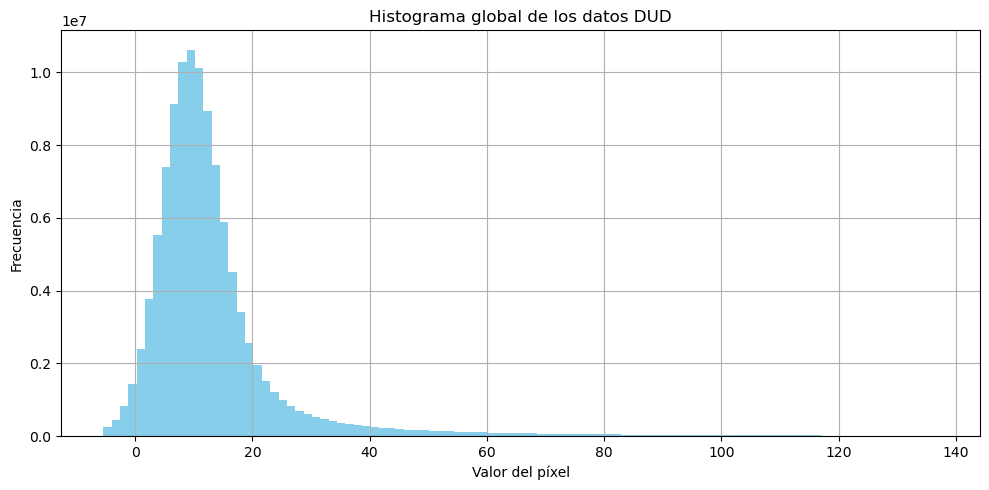

In [3]:
import os
import numpy as np
from astropy.io import fits
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil

# Directorio raíz para los archivos ACS
base_path = "E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/acs/"
subdirs = ['n1', 'n2']

# Inicializamos variables para estadísticas
min_val = np.inf
max_val = -np.inf
sum_vals = 0
count_vals = 0
hist_bins = 100  # puedes ajustar esto si hace falta
hist_range = None  # calculamos después
hist_total = None
value_counter = Counter()

# Recorremos todos los archivos
print("Procesando archivos...")
for subdir in subdirs:
    dir_path = os.path.join(base_path, subdir)
    files = [f for f in os.listdir(dir_path) if f.endswith('.fits')]

    for file in tqdm(files, desc=f"Procesando {subdir}"):
        file_path = os.path.join(dir_path, file)

        try:
            with fits.open(file_path, memmap=True) as hdul:
                for hdu in hdul:
                    if hdu.data is not None:
                        data = hdu.data.astype(np.float32).flatten()
                        data = data[np.isfinite(data)]  # eliminar NaNs o infinitos

                        # Estadísticas simples
                        min_val = min(min_val, data.min())
                        max_val = max(max_val, data.max())
                        sum_vals += data.sum()
                        count_vals += data.size

                        # Histograma incremental
                        if hist_range is None:
                            hist_range = (data.min(), data.max())

                        hist, _ = np.histogram(data, bins=hist_bins, range=hist_range)
                        hist_total = hist if hist_total is None else hist_total + hist

                        # Moda aproximada (más frecuente valor redondeado)
                        rounded = np.round(data, 7)  # precisión a 3 decimales
                        value_counter.update(rounded)

        except Exception as e:
            print(f"Error procesando {file_path}: {e}")
            # Determinar subcarpeta de origen (n1 o n2)
            subdir_corrupt = os.path.basename(os.path.dirname(file_path))
            destino_dir = os.path.join(base_path, "Corruptos", subdir_corrupt)

            # Crear carpeta si no existe
            os.makedirs(destino_dir, exist_ok=True)

            # Ruta de destino completa
            destino_path = os.path.join(destino_dir, file)

            # Mover archivo
            try:
                shutil.move(file_path, destino_path)
                print(f"Archivo movido a {destino_path}")
            except Exception as move_error:
                print(f"Error al mover {file_path}: {move_error}")

# Resultados finales
mean_val = sum_vals / count_vals
mode_val = value_counter.most_common(1)[0][0]

print(f"\nEstadísticas globales:")
print(f"Valor mínimo: {min_val}")
print(f"Valor máximo: {max_val}")
print(f"Media: {mean_val}")
print(f"Moda aproximada (a 7 decimales): {mode_val}")

# Histograma
hist_range = (min_val, max_val)  # <-- clave
bin_edges = np.linspace(hist_range[0], hist_range[1], hist_bins + 1)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

plt.figure(figsize=(10, 5))
plt.bar(bin_centers, hist_total, width=bin_edges[1] - bin_edges[0], color='skyblue')
plt.title("Histograma global de los datos DUD")
plt.xlabel("Valor del píxel")
plt.ylabel("Frecuencia")
plt.grid(True)
# plt.yscale("log")  # descomenta si quieres ver detalles en valores bajos
plt.tight_layout()
plt.show()

In [2]:
from astropy.io import fits

ruta = 'E:/TFM UNIR/GitHub/super-resolucion-galaxias/data/raw/acs/n1/n10_214_81653_ACS.fits'
with fits.open(ruta) as hdul:
    data = hdul[0].data
    print(data.shape)
    print(data)


(51, 51)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


# Despues de haber sido normalizados en .npy


Información de la imagen:
Dimensiones: (25, 26)
Valor mínimo: 0.019631
Valor máximo: 0.024156
Valor medio: 0.020198


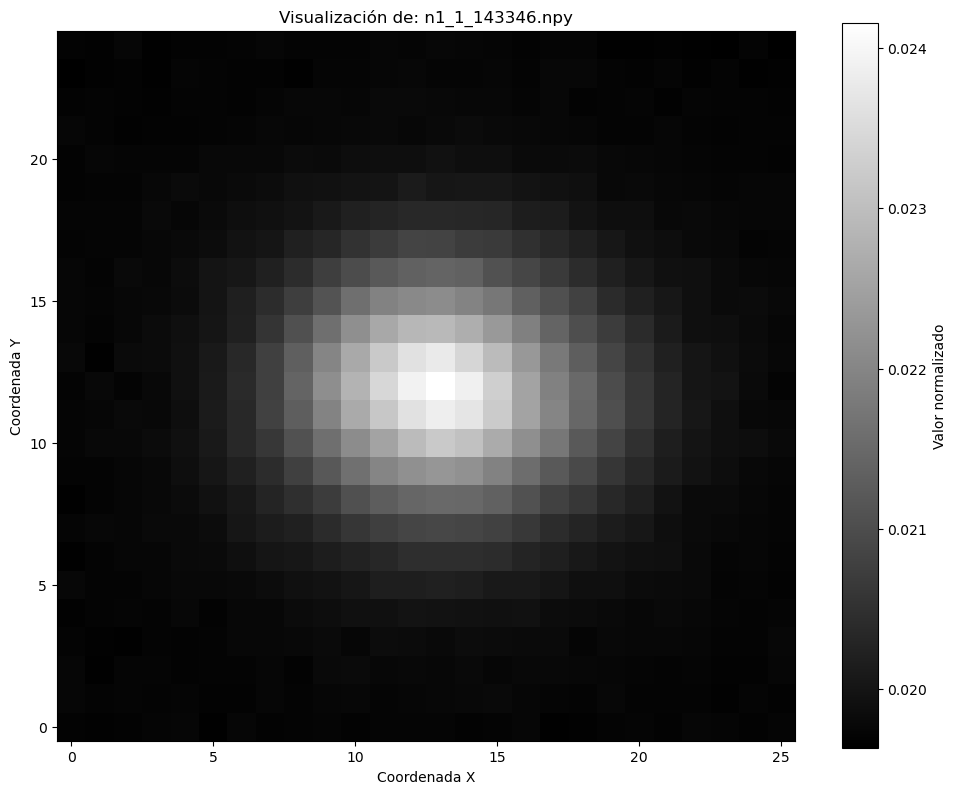


Información de la imagen:
Dimensiones: (89, 89)
Valor mínimo: 0.038131
Valor máximo: 0.039501
Valor medio: 0.038349


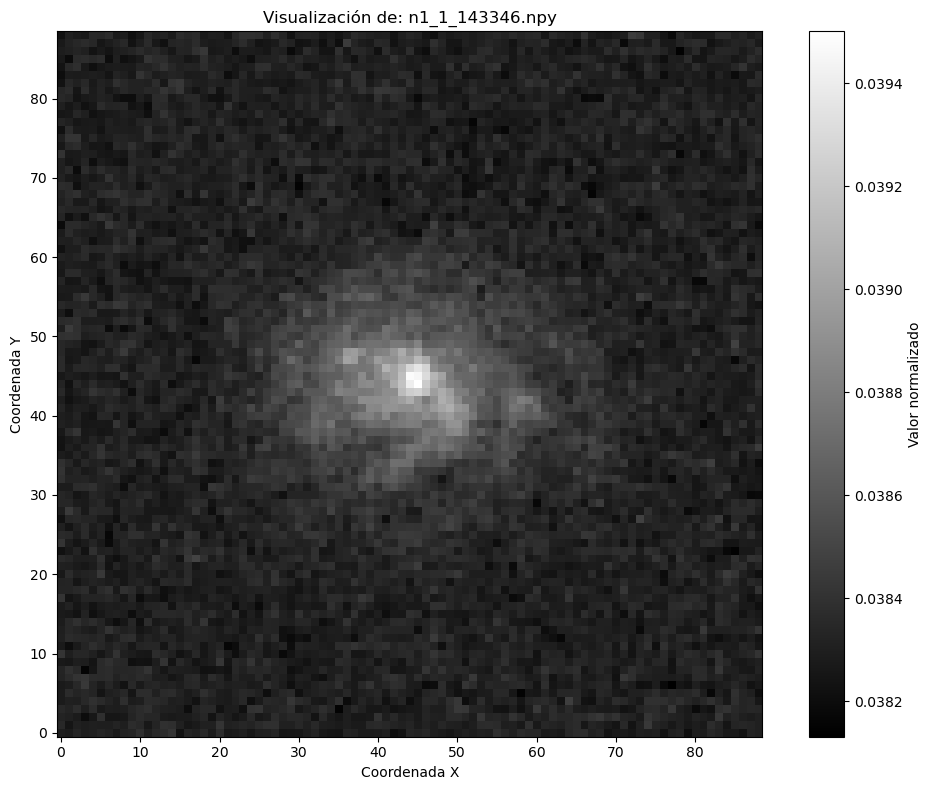

In [5]:
# Examinar un archivo
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # Para mejor visualización si el rango dinámico es alto

def visualize_npy_image(file_path):
    """
    Visualiza la imagen contenida en un archivo .npy
    """
    # Cargar los datos
    try:
        image_data = np.load(file_path)
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return
    
    # Mostrar información básica
    print("\nInformación de la imagen:")
    print(f"Dimensiones: {image_data.shape}")
    print(f"Valor mínimo: {np.min(image_data):.6f}")
    print(f"Valor máximo: {np.max(image_data):.6f}")
    print(f"Valor medio: {np.mean(image_data):.6f}")
    
    # Crear la visualización
    plt.figure(figsize=(10, 8))
    
    # Usamos imshow para mostrar la imagen
    # Dado que el rango de valores es muy pequeño (0.0196 a 0.0242), ajustamos el contraste
    img = plt.imshow(image_data, 
                    cmap='gray', 
                    origin='lower',
                    vmin=np.min(image_data),
                    vmax=np.max(image_data))
    
    # Añadir barra de color
    plt.colorbar(img, label='Valor normalizado')
    plt.title(f"Visualización de: {file_path.split('/')[-1]}")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()

# Ejemplo de uso - reemplaza con tu ruta real
visualize_npy_image("../data/normaliced/dud/n1_1_143346.npy")
visualize_npy_image("../data/normaliced/acs/n1_1_143346.npy")


Analizando resoluciones en ../data/process/dud/...

Estadísticas de Resolución:
Ancho mínimo: 2 px
Ancho máximo: 152 px
Alto mínimo: 3 px
Alto máximo: 152 px
Ancho promedio: 20.67 px
Alto promedio: 20.67 px

Cuartiles de Ancho:
  Q1 (25%): 13.00 px
  Mediana (Q2/50%): 17.00 px
  Q3 (75%): 24.00 px

Cuartiles de Alto:
  Q1 (25%): 13.00 px
  Mediana (Q2/50%): 17.00 px
  Q3 (75%): 24.00 px

Resoluciones encontradas (ancho x alto):
2x3 px: 1 archivos (0.0%)
3x3 px: 1 archivos (0.0%)
4x4 px: 1 archivos (0.0%)
4x5 px: 2 archivos (0.0%)
5x4 px: 2 archivos (0.0%)
5x5 px: 5 archivos (0.0%)
5x6 px: 2 archivos (0.0%)
6x5 px: 4 archivos (0.0%)
6x6 px: 8 archivos (0.0%)
6x7 px: 9 archivos (0.1%)
7x6 px: 3 archivos (0.0%)
7x7 px: 29 archivos (0.2%)
7x8 px: 30 archivos (0.2%)
8x7 px: 22 archivos (0.1%)
8x8 px: 113 archivos (0.7%)
8x9 px: 35 archivos (0.2%)
9x8 px: 41 archivos (0.3%)
9x9 px: 346 archivos (2.1%)
9x10 px: 84 archivos (0.5%)
10x9 px: 104 archivos (0.6%)
10x10 px: 406 archivos (2.5%)
10x

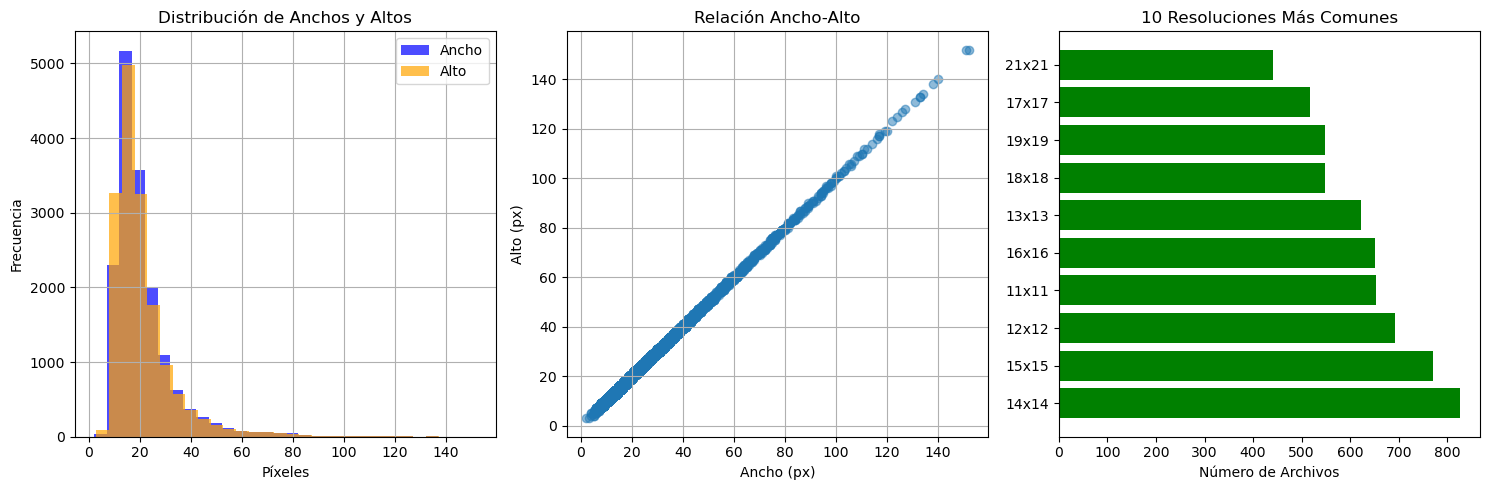


Analizando resoluciones en ../data/process/acs/...

Estadísticas de Resolución:
Ancho mínimo: 7 px
Ancho máximo: 521 px
Alto mínimo: 7 px
Alto máximo: 521 px
Ancho promedio: 70.87 px
Alto promedio: 70.87 px

Cuartiles de Ancho:
  Q1 (25%): 45.00 px
  Mediana (Q2/50%): 58.00 px
  Q3 (75%): 82.00 px

Cuartiles de Alto:
  Q1 (25%): 45.00 px
  Mediana (Q2/50%): 58.00 px
  Q3 (75%): 82.00 px

Resoluciones encontradas (ancho x alto):
7x7 px: 1 archivos (0.0%)
10x10 px: 1 archivos (0.0%)
14x14 px: 3 archivos (0.0%)
17x17 px: 9 archivos (0.1%)
21x21 px: 21 archivos (0.1%)
24x24 px: 62 archivos (0.4%)
27x27 px: 170 archivos (1.1%)
31x31 px: 471 archivos (2.9%)
34x34 px: 646 archivos (4.0%)
38x38 px: 950 archivos (5.9%)
41x41 px: 1022 archivos (6.3%)
45x45 px: 965 archivos (6.0%)
48x48 px: 1132 archivos (7.0%)
51x51 px: 1079 archivos (6.7%)
55x55 px: 974 archivos (6.0%)
58x58 px: 815 archivos (5.1%)
62x62 px: 803 archivos (5.0%)
65x65 px: 776 archivos (4.8%)
69x69 px: 525 archivos (3.3%)
72x72 

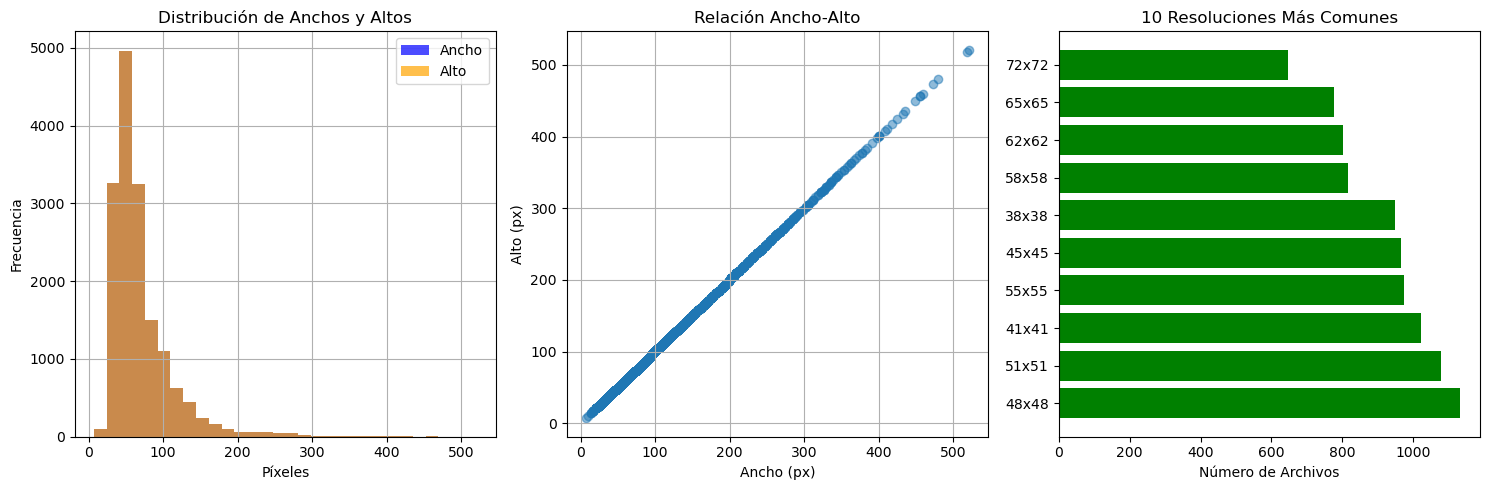

defaultdict(int,
            {(34, 34): 646,
             (58, 58): 815,
             (151, 151): 57,
             (69, 69): 525,
             (79, 79): 400,
             (117, 117): 144,
             (31, 31): 471,
             (127, 127): 85,
             (51, 51): 1079,
             (38, 38): 950,
             (62, 62): 803,
             (41, 41): 1022,
             (75, 75): 501,
             (223, 223): 9,
             (106, 106): 193,
             (233, 233): 11,
             (65, 65): 776,
             (113, 113): 129,
             (55, 55): 974,
             (48, 48): 1132,
             (456, 456): 2,
             (72, 72): 648,
             (45, 45): 965,
             (82, 82): 504,
             (103, 103): 186,
             (93, 93): 278,
             (89, 89): 306,
             (161, 161): 50,
             (99, 99): 218,
             (291, 291): 3,
             (86, 86): 295,
             (261, 261): 11,
             (27, 27): 170,
             (110, 110): 137,
             

In [19]:
# Examinar resoluciones de una carpeta
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_and_plot_resolutions(dud_dir):
    """
    Analiza resoluciones, muestra estadísticas y genera gráficos
    """
    if not os.path.exists(dud_dir):
        print(f"Error: El directorio {dud_dir} no existe")
        return
    
    # Diccionarios para almacenar datos
    resolutions = defaultdict(int)
    widths = []
    heights = []
    
    # Obtener lista de archivos .fits
    dud_files = [f for f in os.listdir(dud_dir) if f.endswith(".fits")]
    
    if not dud_files:
        print("No se encontraron archivos .fits en el directorio")
        return
    
    print(f"\nAnalizando resoluciones en {dud_dir}...")
    
    for dud_file in dud_files:
        dud_path = os.path.join(dud_dir, dud_file)
        
        try:
            with fits.open(dud_path) as hdul:
                # Buscar la extensión con datos
                for hdu in hdul:
                    if hdu.data is not None:
                        height, width = hdu.data.shape
                        resolutions[(width, height)] += 1
                        widths.append(width)
                        heights.append(height)
                        break
        except Exception as e:
            print(f"Error procesando {dud_file}: {e}")
    
    # Calcular estadísticas
    min_width, max_width = min(widths), max(widths)
    min_height, max_height = min(heights), max(heights)
    
    # Calcular promedios
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)

    # Calcular cuartiles para anchos
    q1_width = np.percentile(widths, 25)
    median_width = np.percentile(widths, 50) # Mediana (Q2)
    q3_width = np.percentile(widths, 75)

    # Calcular cuartiles para altos
    q1_height = np.percentile(heights, 25)
    median_height = np.percentile(heights, 50) # Mediana (Q2)
    q3_height = np.percentile(heights, 75)

    # Mostrar resultados
    print("\n" + "="*50)
    print("Estadísticas de Resolución:")
    print("="*50)
    print(f"Ancho mínimo: {min_width} px")
    print(f"Ancho máximo: {max_width} px")
    print(f"Alto mínimo: {min_height} px")
    print(f"Alto máximo: {max_height} px")
    print(f"Ancho promedio: {avg_width:.2f} px")
    print(f"Alto promedio: {avg_height:.2f} px")
    
    print("\nCuartiles de Ancho:")
    print(f"  Q1 (25%): {q1_width:.2f} px")
    print(f"  Mediana (Q2/50%): {median_width:.2f} px")
    print(f"  Q3 (75%): {q3_width:.2f} px")

    print("\nCuartiles de Alto:")
    print(f"  Q1 (25%): {q1_height:.2f} px")
    print(f"  Mediana (Q2/50%): {median_height:.2f} px")
    print(f"  Q3 (75%): {q3_height:.2f} px")
    
    print("\nResoluciones encontradas (ancho x alto):")
    for (w, h), count in sorted(resolutions.items()):
        print(f"{w}x{h} px: {count} archivos ({count/len(dud_files):.1%})")
    
    print(f"\nTotal de archivos analizados: {len(dud_files)}")
    print(f"Resoluciones únicas encontradas: {len(resolutions)}")
    
    # Crear gráficos
    plt.figure(figsize=(15, 5))
    
    # Gráfico 1: Distribución de anchos y altos
    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=30, alpha=0.7, label='Ancho', color='blue')
    plt.hist(heights, bins=30, alpha=0.7, label='Alto', color='orange')
    plt.title('Distribución de Anchos y Altos')
    plt.xlabel('Píxeles')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    
    # Gráfico 2: Dispersión de resoluciones
    plt.subplot(1, 3, 2)
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Relación Ancho-Alto')
    plt.xlabel('Ancho (px)')
    plt.ylabel('Alto (px)')
    plt.grid(True)
    
    # Gráfico 3: Resoluciones más comunes
    plt.subplot(1, 3, 3)
    common_res = sorted(resolutions.items(), key=lambda x: -x[1])[:10]
    res_labels = [f"{w}x{h}" for (w, h), _ in common_res]
    counts = [count for _, count in common_res]
    plt.barh(res_labels, counts, color='green')
    plt.title('10 Resoluciones Más Comunes')
    plt.xlabel('Número de Archivos')
    plt.tight_layout()
    
    plt.show()
    
    return resolutions

# Ejemplo de uso:
analyze_and_plot_resolutions("../data/process/dud/")
analyze_and_plot_resolutions("../data/process/acs/")


Buscando ejemplos de downsampling y padding en DUD...


  0%|                                                                               | 3/16114 [00:00<00:54, 296.56it/s]

Ejemplo de Downsampling (DUD): n10_102_121375.npy (Original: (44, 44))
Ejemplo de Padding (DUD): n10_0_87915.npy (Original: (10, 10))

--- Visualizando: Imagen DUD Reescalada (Downsampled) (ID: n10_102_121375) ---


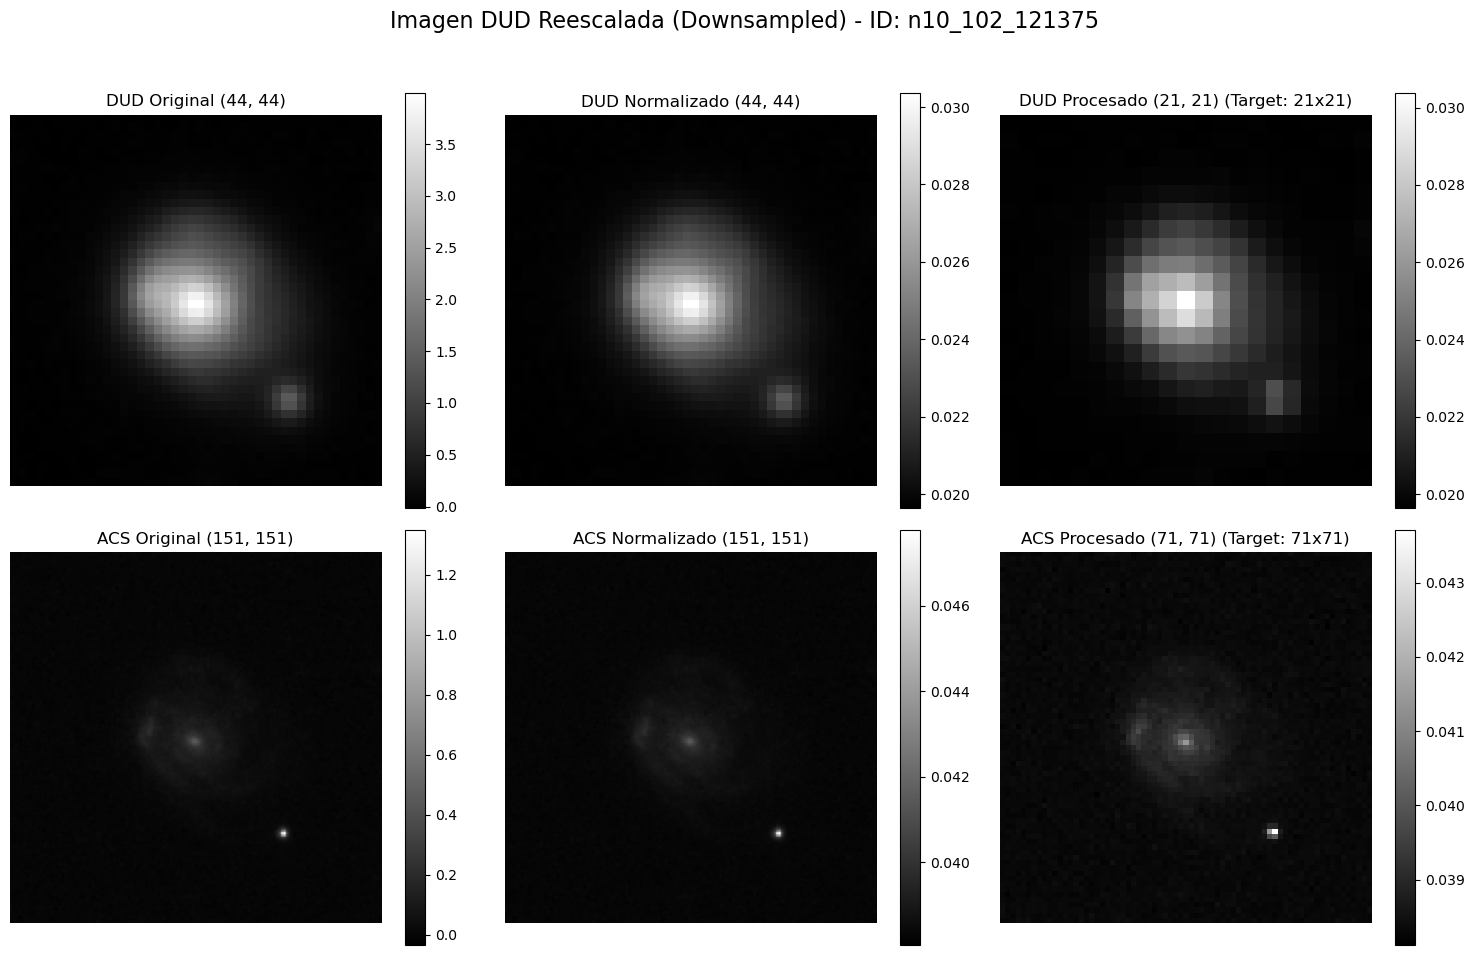


--- Visualizando: Imagen DUD Rellenada (Padded) (ID: n10_0_87915) ---


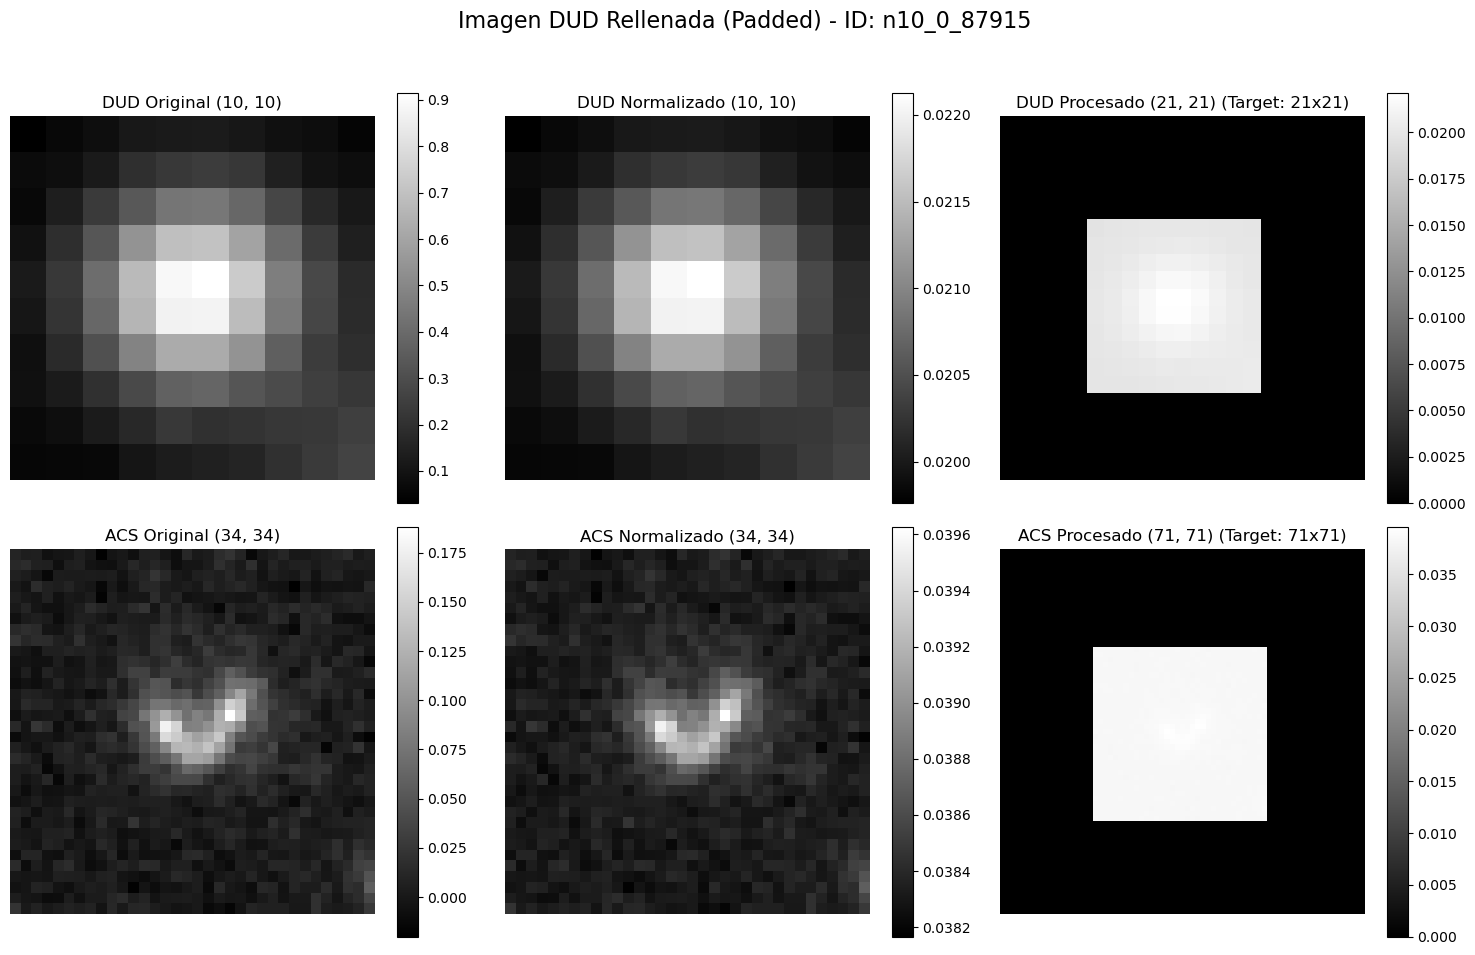


Análisis de ejemplos completado.


In [8]:
import os
import numpy as np
from astropy.io import fits # Necesario para leer los .fits originales para resoluciones
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Configuración de directorios y resoluciones (debe coincidir con tu procesamiento) ---
original_dud_dir = "../data/process/dud/"
original_acs_dir = "../data/process/acs/"

processed_dud_npy_dir = "../data/normaliced/dud_processed_lanczos/"
processed_acs_npy_dir = "../data/normaliced/acs_processed_lanczos/"

normalized_dud_dir = "../data/normaliced/dud/" # Donde se guardaron los .npy normalizados
normalized_acs_dir = "../data/normaliced/acs/" # Donde se guardaron los .npy normalizados

target_dud_resolution = 21
target_acs_resolution = 71

# --- Funciones auxiliares para obtener resoluciones originales ---
def get_original_fits_resolution(filepath):
    """Obtiene la resolución de un archivo FITS original."""
    try:
        with fits.open(filepath, verify='silentfix') as hdul:
            for hdu in hdul:
                if hdu.data is not None:
                    return hdu.data.shape # (height, width)
    except Exception as e:
        print(f"Error al leer la resolución de {filepath}: {e}")
    return None

def find_processed_examples(dud_original_dir, processed_dud_dir, target_res):
    """
    Busca un archivo DUD que fue downsampled y otro que fue padded.
    Devuelve los nombres base de los archivos.
    """
    downsampled_file = None
    padded_file = None

    print("\nBuscando ejemplos de downsampling y padding en DUD...")
    
    # Obtenemos todos los archivos .npy procesados de DUD
    processed_files = [f for f in os.listdir(processed_dud_dir) if f.endswith(".npy")]

    for filename_npy in tqdm(processed_files):
        base_name = filename_npy.replace(".npy", "")
        original_fits_path = os.path.join(dud_original_dir, base_name + ".fits")

        original_shape = get_original_fits_resolution(original_fits_path)
        
        if original_shape is None:
            continue # No pudimos obtener la resolución original

        original_height, original_width = original_shape

        # Si el ancho original es mayor que la resolución objetivo, fue downsampled
        if original_width > target_res and downsampled_file is None:
            downsampled_file = base_name
        
        # Si el ancho original es menor que la resolución objetivo, fue padded
        if original_width < target_res and padded_file is None:
            padded_file = base_name
        
        if downsampled_file and padded_file:
            break # Ya encontramos ambos
            
    if downsampled_file:
        print(f"Ejemplo de Downsampling (DUD): {downsampled_file}.npy (Original: {get_original_fits_resolution(os.path.join(dud_original_dir, downsampled_file + '.fits'))})")
    else:
        print("No se encontró un ejemplo de downsampling en DUD.")

    if padded_file:
        print(f"Ejemplo de Padding (DUD): {padded_file}.npy (Original: {get_original_fits_resolution(os.path.join(dud_original_dir, padded_file + '.fits'))})")
    else:
        print("No se encontró un ejemplo de padding en DUD.")

    return downsampled_file, padded_file

# --- Función para mostrar las imágenes ---
def plot_images(file_base_name, original_dud_fits_dir, original_acs_fits_dir, 
                normalized_dud_dir, normalized_acs_dir, 
                processed_dud_dir, processed_acs_dir, 
                target_dud_res, target_acs_res, plot_title):
    """
    Carga y muestra las imágenes originales, normalizadas y procesadas de una pareja DUD-ACS.
    """
    print(f"\n--- Visualizando: {plot_title} (ID: {file_base_name}) ---")

    # Rutas para DUD
    original_dud_fits_path = os.path.join(original_dud_fits_dir, file_base_name + ".fits")
    normalized_dud_npy_path = os.path.join(normalized_dud_dir, file_base_name + ".npy")
    processed_dud_npy_path = os.path.join(processed_dud_dir, file_base_name + ".npy")

    # Rutas para ACS (la pareja)
    original_acs_fits_path = os.path.join(original_acs_fits_dir, file_base_name + "_ACS.fits")
    normalized_acs_npy_path = os.path.join(normalized_acs_dir, file_base_name + ".npy")
    processed_acs_npy_path = os.path.join(processed_acs_dir, file_base_name + ".npy")

    # Cargar datos
    original_dud_data = get_original_fits_data(original_dud_fits_path)
    normalized_dud_data = np.load(normalized_dud_npy_path) if os.path.exists(normalized_dud_npy_path) else None
    processed_dud_data = np.load(processed_dud_npy_path) if os.path.exists(processed_dud_npy_path) else None

    original_acs_data = get_original_fits_data(original_acs_fits_path)
    normalized_acs_data = np.load(normalized_acs_npy_path) if os.path.exists(normalized_acs_npy_path) else None
    processed_acs_data = np.load(processed_acs_npy_path) if os.path.exists(processed_acs_npy_path) else None

    # Configurar la figura
    fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # 2 filas (DUD, ACS), 3 columnas (Original, Normalizado, Procesado)
    fig.suptitle(f'{plot_title} - ID: {file_base_name}', fontsize=16)

    titles_dud = [f'DUD Original {original_dud_data.shape if original_dud_data is not None else "N/A"}',
                  f'DUD Normalizado {normalized_dud_data.shape if normalized_dud_data is not None else "N/A"}',
                  f'DUD Procesado {processed_dud_data.shape if processed_dud_data is not None else "N/A"} (Target: {target_dud_res}x{target_dud_res})']
    
    titles_acs = [f'ACS Original {original_acs_data.shape if original_acs_data is not None else "N/A"}',
                  f'ACS Normalizado {normalized_acs_data.shape if normalized_acs_data is not None else "N/A"}',
                  f'ACS Procesado {processed_acs_data.shape if processed_acs_data is not None else "N/A"} (Target: {target_acs_res}x{target_acs_res})']

    images_dud = [original_dud_data, normalized_dud_data, processed_dud_data]
    images_acs = [original_acs_data, normalized_acs_data, processed_acs_data]

    # Mostrar DUD
    for i, (img, title) in enumerate(zip(images_dud, titles_dud)):
        ax = axes[0, i]
        if img is not None:
            im = ax.imshow(img, cmap='gray', origin='lower')
            fig.colorbar(im, ax=ax)
        ax.set_title(title)
        ax.axis('off')

    # Mostrar ACS
    for i, (img, title) in enumerate(zip(images_acs, titles_acs)):
        ax = axes[1, i]
        if img is not None:
            im = ax.imshow(img, cmap='gray', origin='lower')
            fig.colorbar(im, ax=ax)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def get_original_fits_data(filepath):
    """Carga los datos de un archivo FITS original."""
    try:
        with fits.open(filepath, verify='silentfix') as hdul:
            for hdu in hdul:
                if hdu.data is not None:
                    return hdu.data
    except Exception as e:
        print(f"Error al cargar datos de {filepath}: {e}")
    return None

# --- Ejecución ---
downsampled_example, padded_example = find_processed_examples(original_dud_dir, processed_dud_npy_dir, target_dud_resolution)

if downsampled_example:
    plot_images(downsampled_example, original_dud_dir, original_acs_dir,
                normalized_dud_dir, normalized_acs_dir,
                processed_dud_npy_dir, processed_acs_npy_dir,
                target_dud_resolution, target_acs_resolution,
                "Imagen DUD Reescalada (Downsampled)")

if padded_example:
    plot_images(padded_example, original_dud_dir, original_acs_dir,
                normalized_dud_dir, normalized_acs_dir,
                processed_dud_npy_dir, processed_acs_npy_dir,
                target_dud_resolution, target_acs_resolution,
                "Imagen DUD Rellenada (Padded)")

print("\nAnálisis de ejemplos completado.")


Buscando ejemplos de downsampling y padding en DUD...


  0%|                                                                               | 3/16114 [00:00<00:47, 339.47it/s]

Ejemplo de Downsampling (DUD): n10_102_121375.npy (Original: (44, 44))
Ejemplo de Padding (DUD): n10_0_87915.npy (Original: (10, 10))

--- Visualizando: Imagen DUD Reescalada (Downsampled) (ID: n10_102_121375) ---


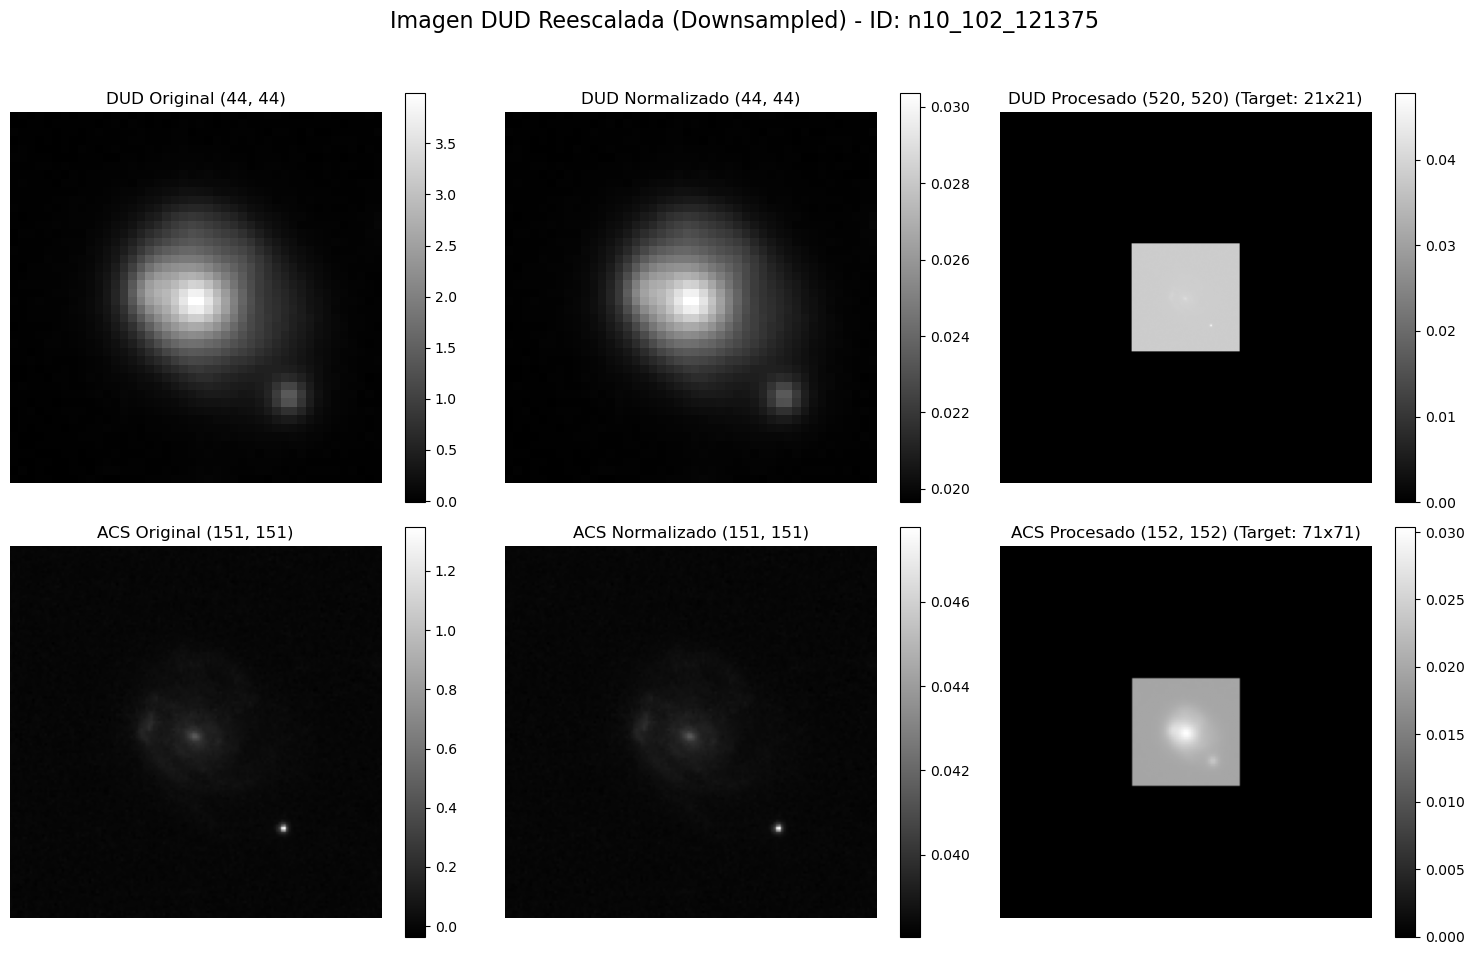


--- Visualizando: Imagen DUD Rellenada (Padded) (ID: n10_0_87915) ---


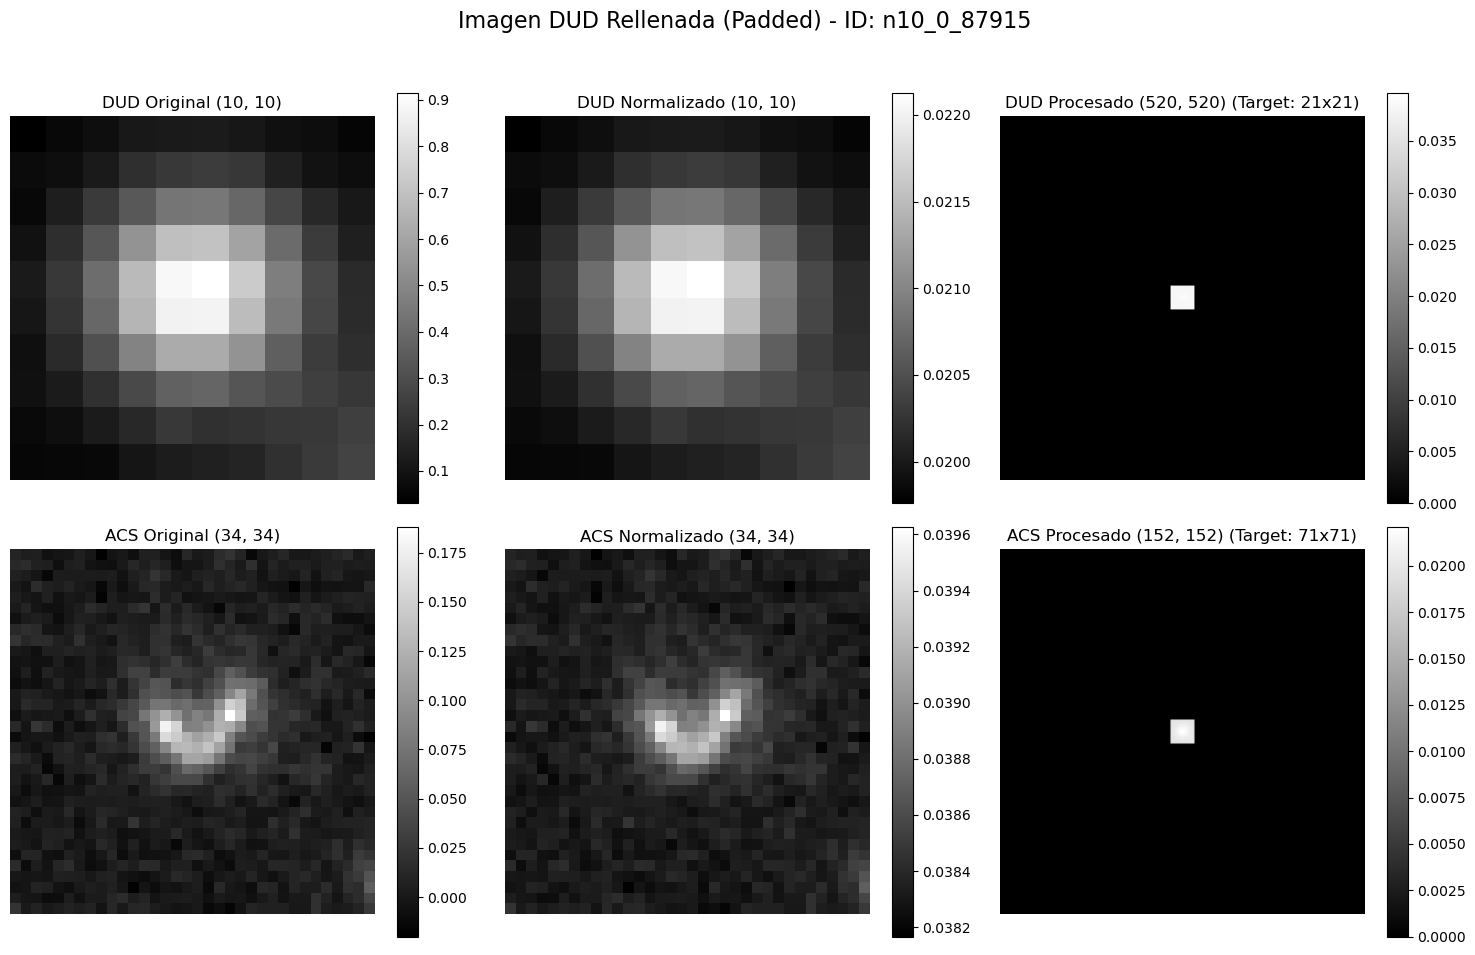


Análisis de ejemplos completado.


In [10]:
# --- Configuración de directorios y resoluciones (debe coincidir con tu procesamiento) ---
original_dud_dir = "../data/process/dud/"
original_acs_dir = "../data/process/acs/"

processed_dud_npy_dir = "../data/normaliced/pading/acs/"
processed_acs_npy_dir = "../data/normaliced/pading/dud/"

normalized_dud_dir = "../data/normaliced/dud/" # Donde se guardaron los .npy normalizados
normalized_acs_dir = "../data/normaliced/acs/" # Donde se guardaron los .npy normalizados

target_dud_resolution = 21
target_acs_resolution = 71

# --- Ejecución ---
downsampled_example, padded_example = find_processed_examples(original_dud_dir, processed_dud_npy_dir, target_dud_resolution)

if downsampled_example:
    plot_images(downsampled_example, original_dud_dir, original_acs_dir,
                normalized_dud_dir, normalized_acs_dir,
                processed_dud_npy_dir, processed_acs_npy_dir,
                target_dud_resolution, target_acs_resolution,
                "Imagen DUD Reescalada (Downsampled)")

if padded_example:
    plot_images(padded_example, original_dud_dir, original_acs_dir,
                normalized_dud_dir, normalized_acs_dir,
                processed_dud_npy_dir, processed_acs_npy_dir,
                target_dud_resolution, target_acs_resolution,
                "Imagen DUD Rellenada (Padded)")

print("\nAnálisis de ejemplos completado.")


Visualizando las 10 pares de imágenes aumentadas (después de las 20 primeras)...


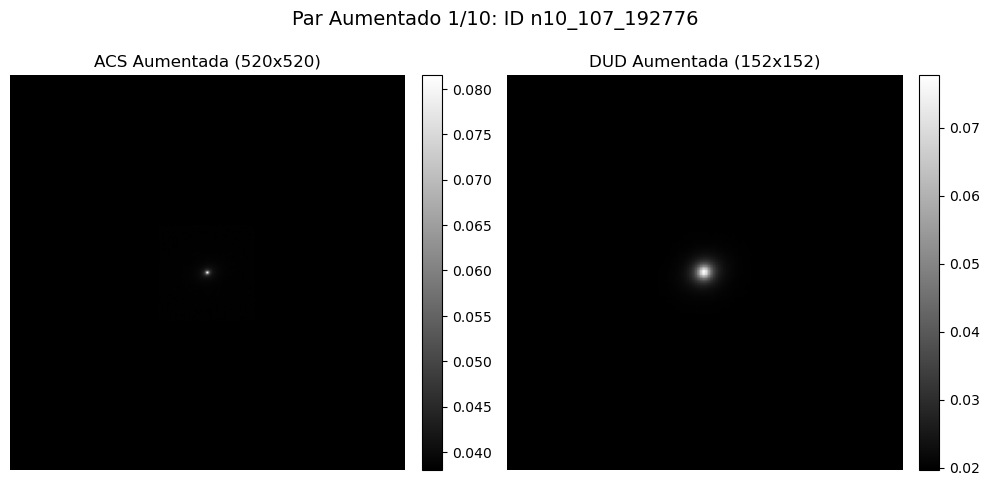

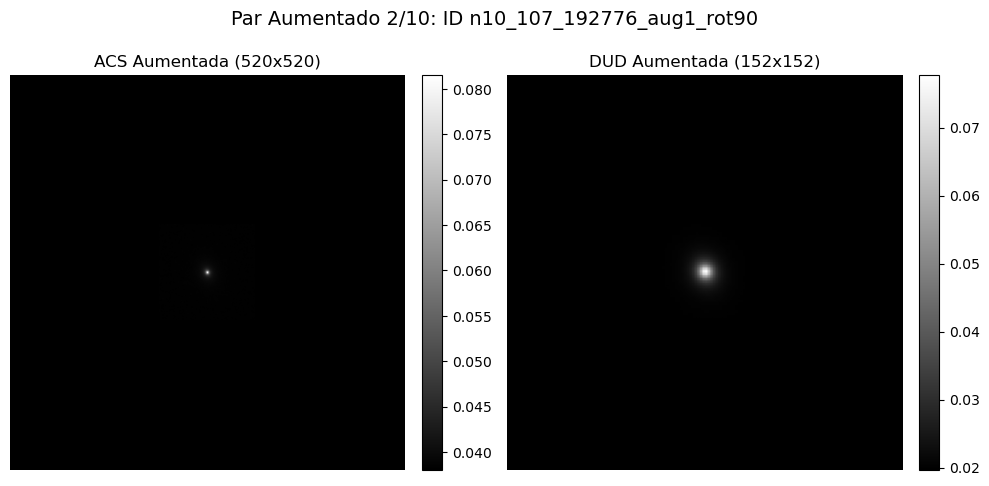

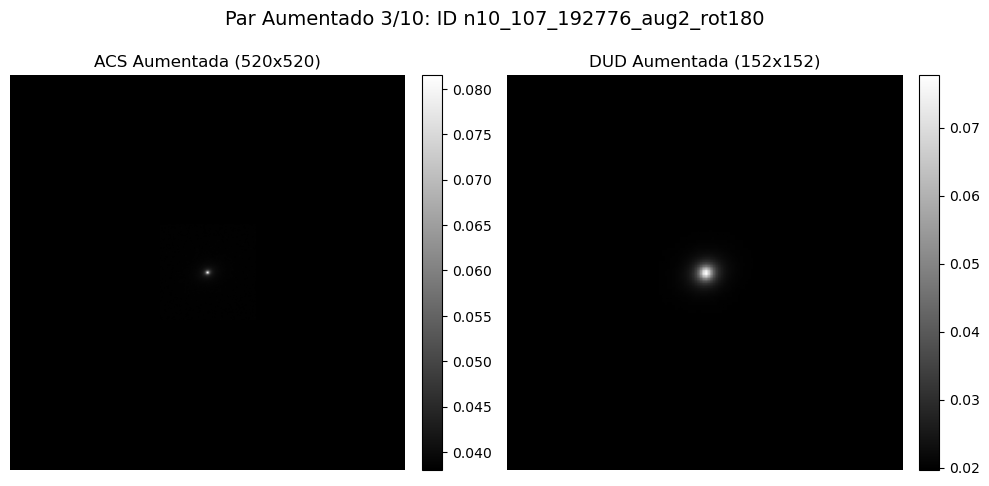

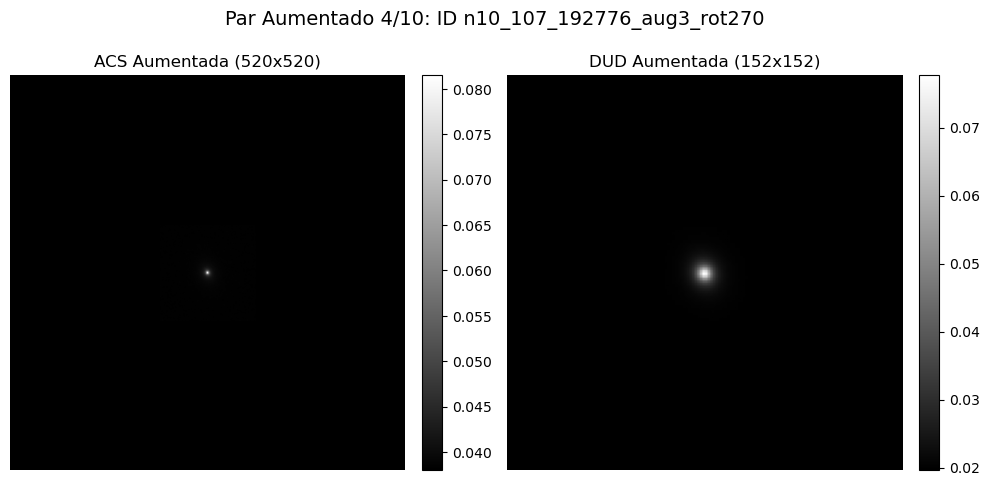

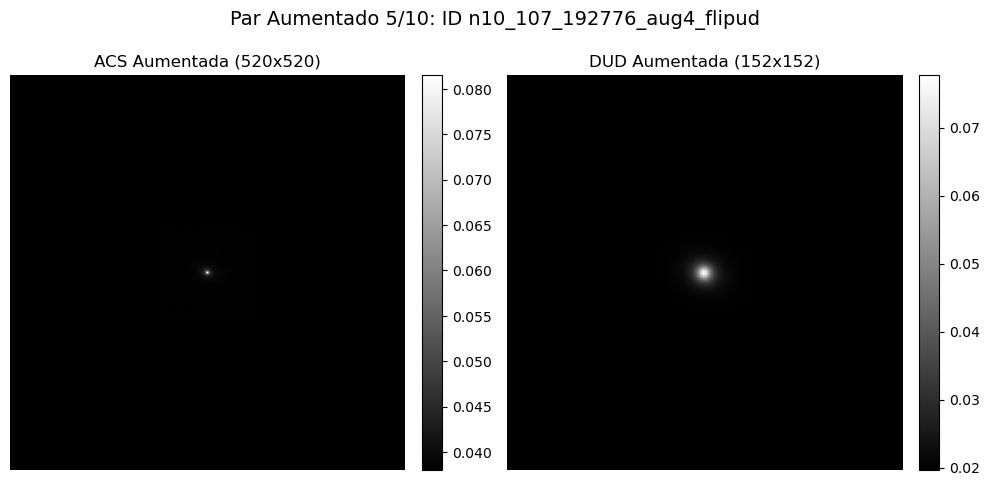

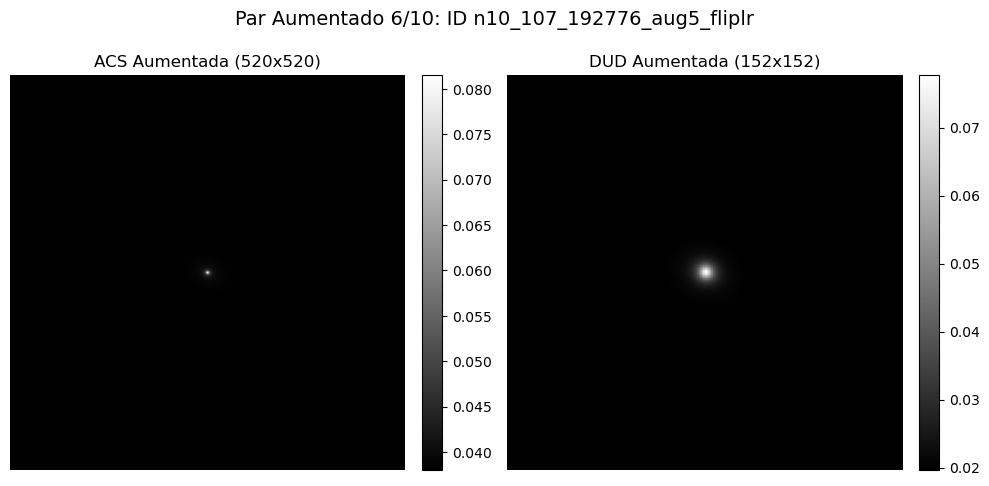

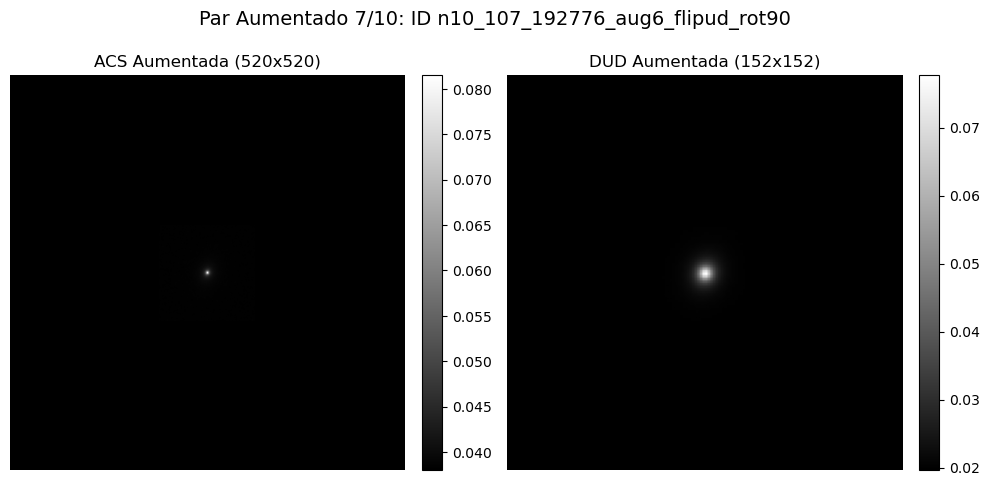

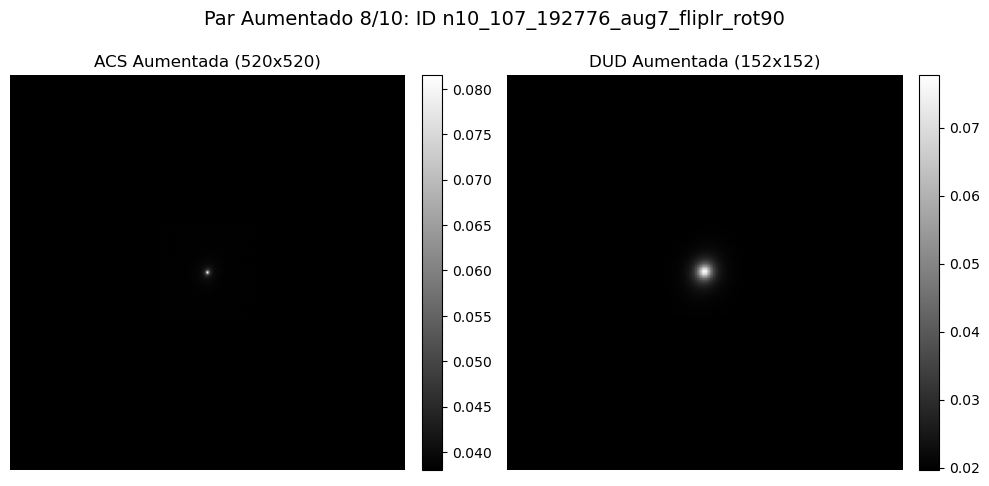

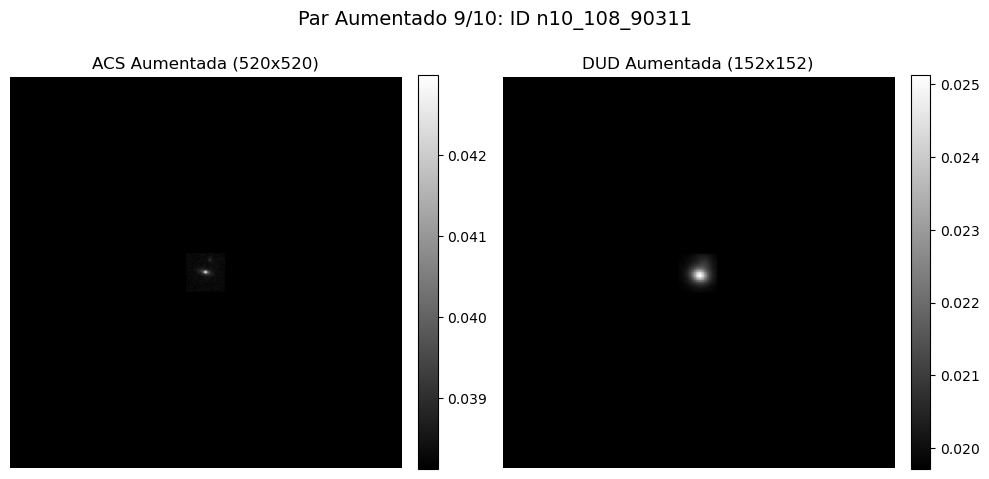

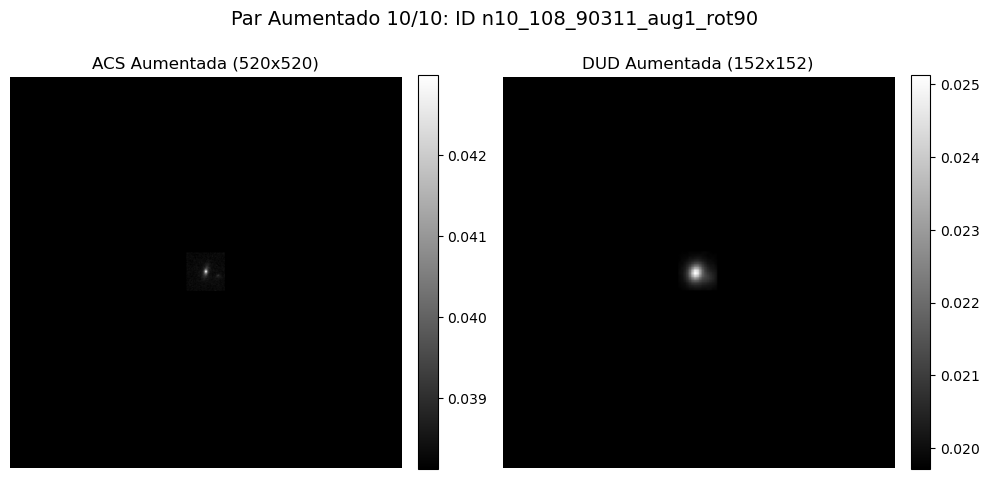

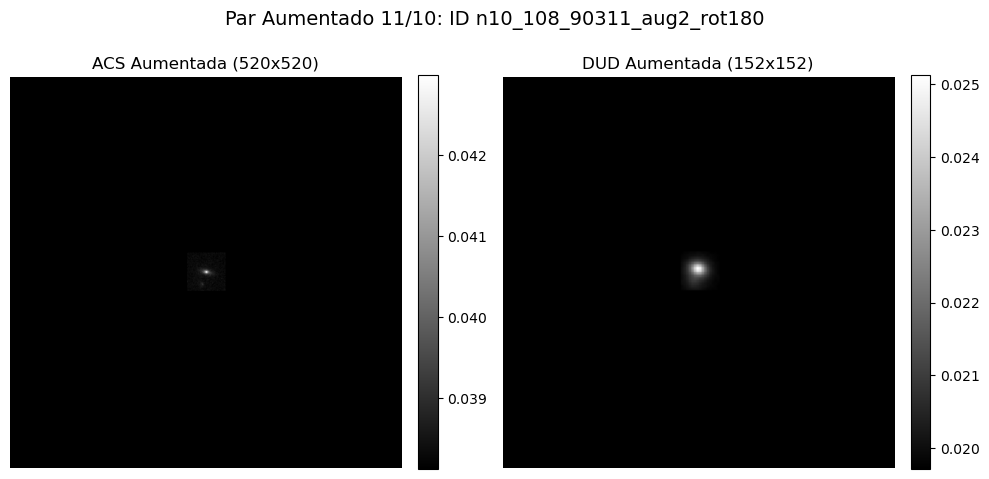

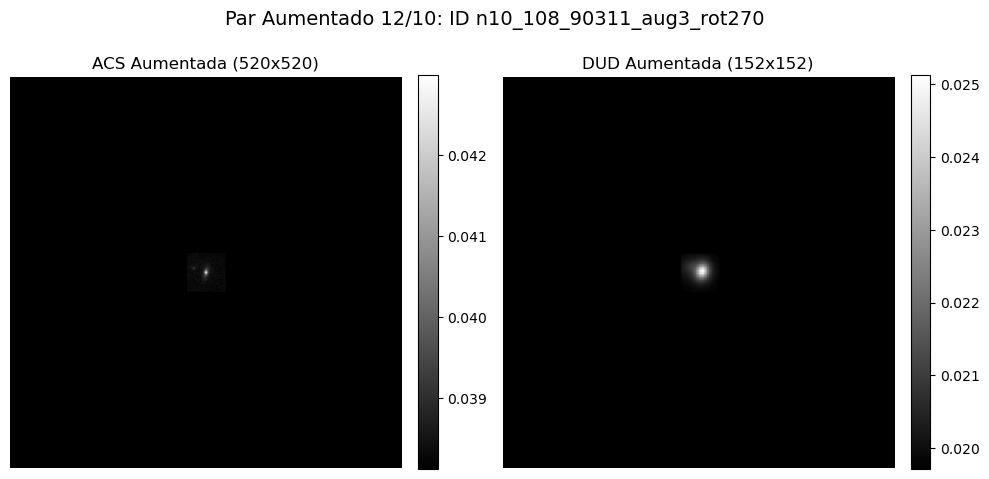

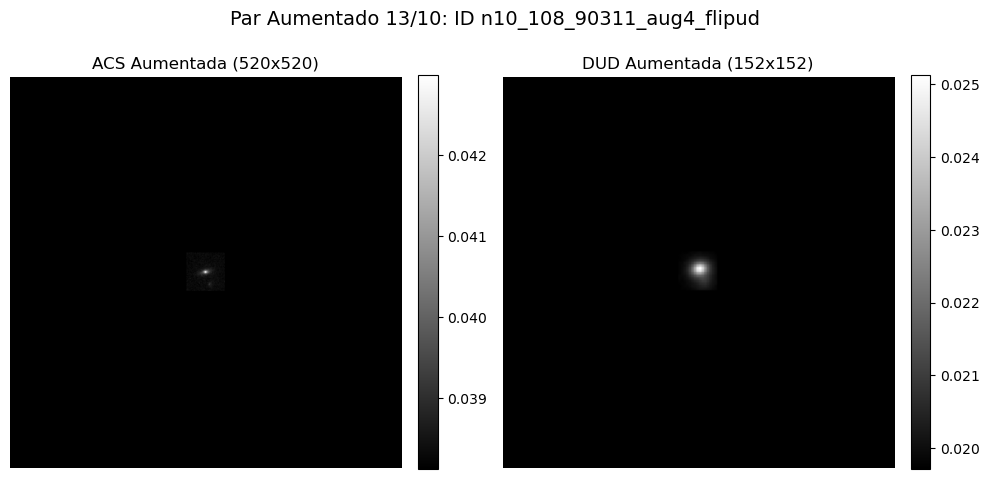

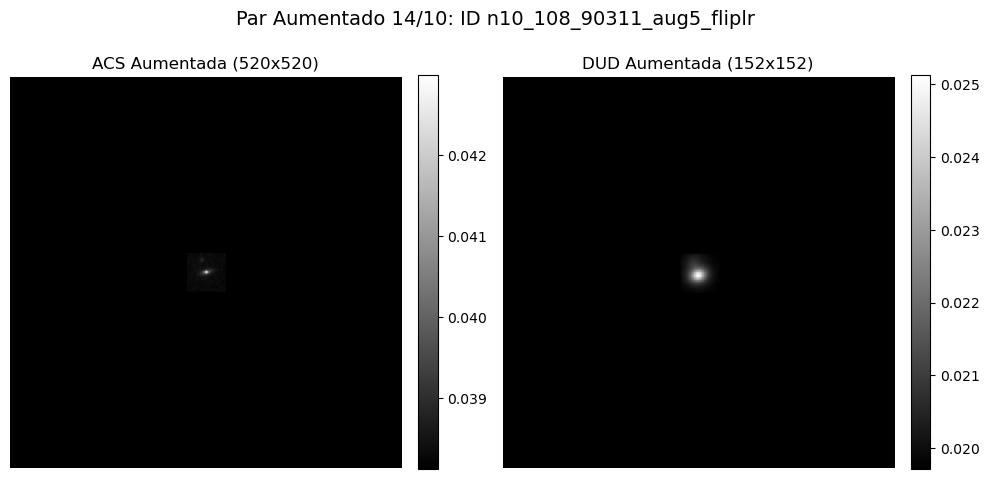

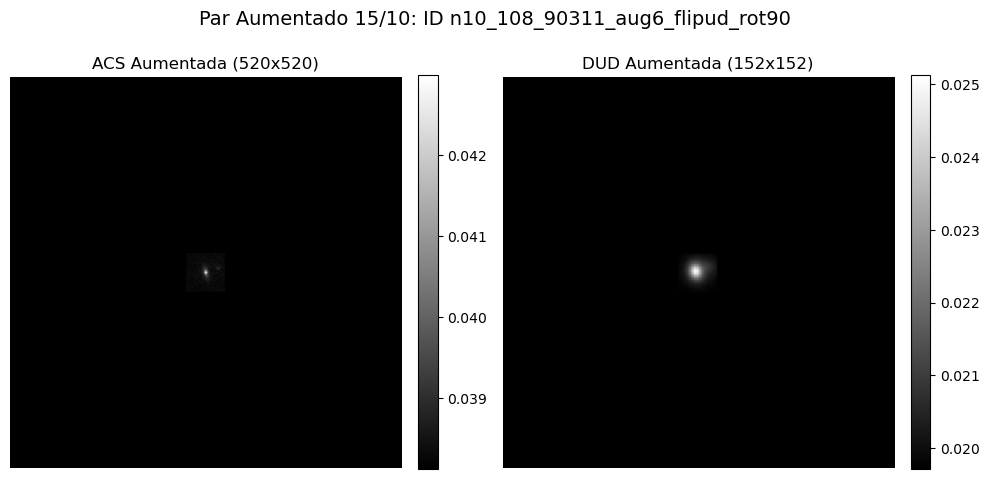

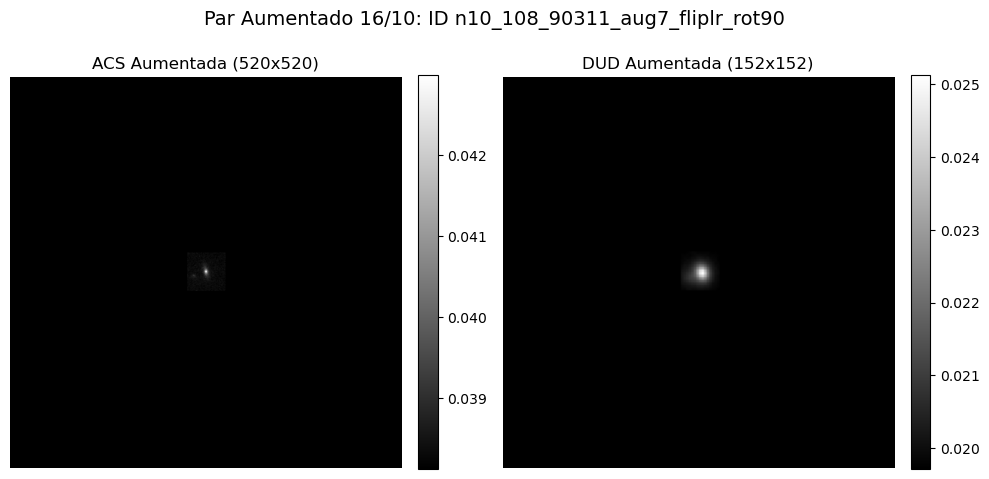

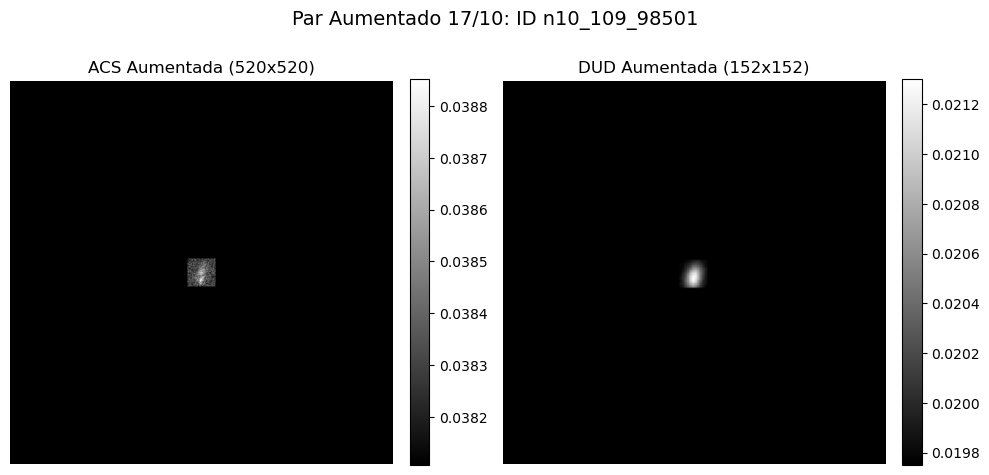

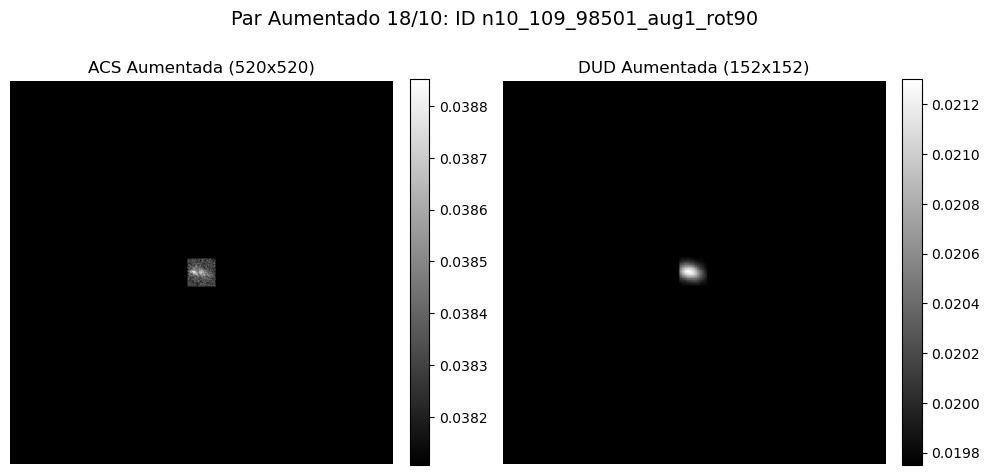

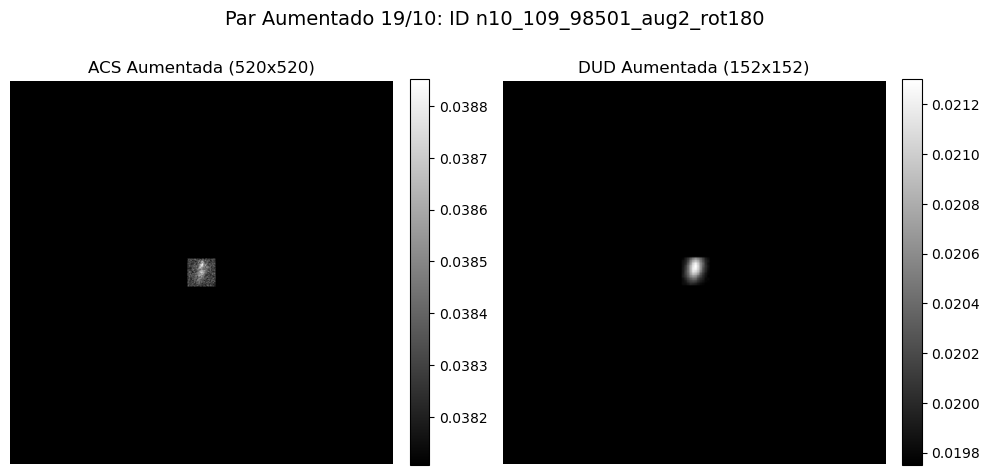

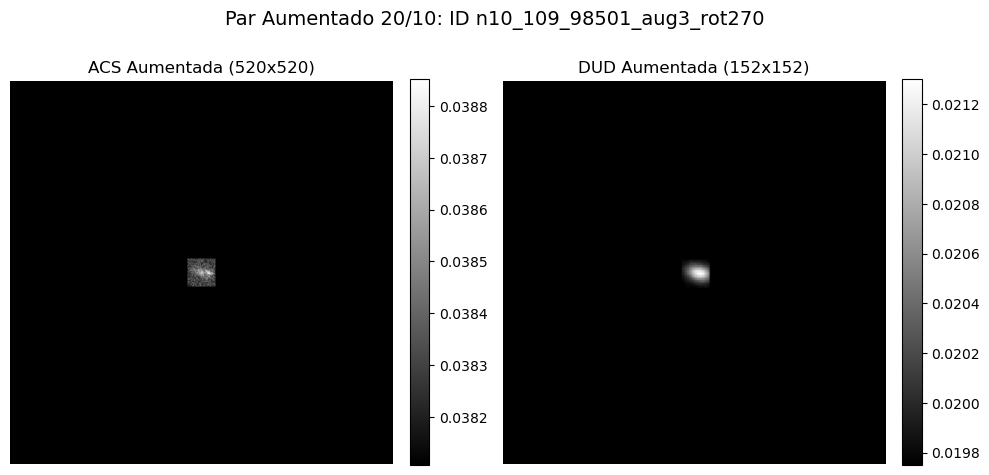

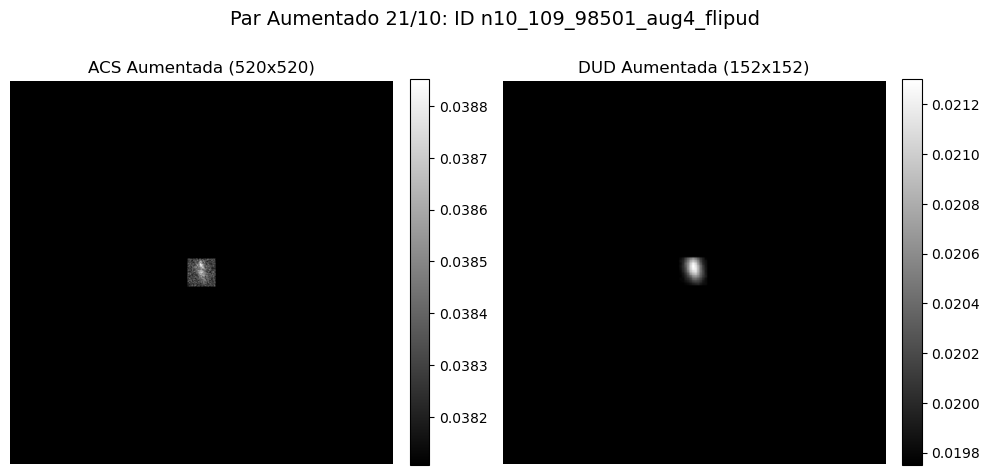

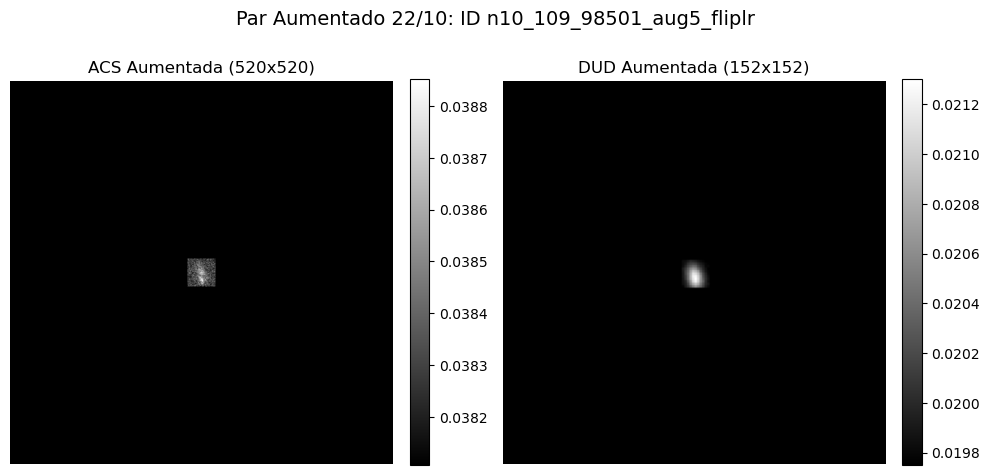

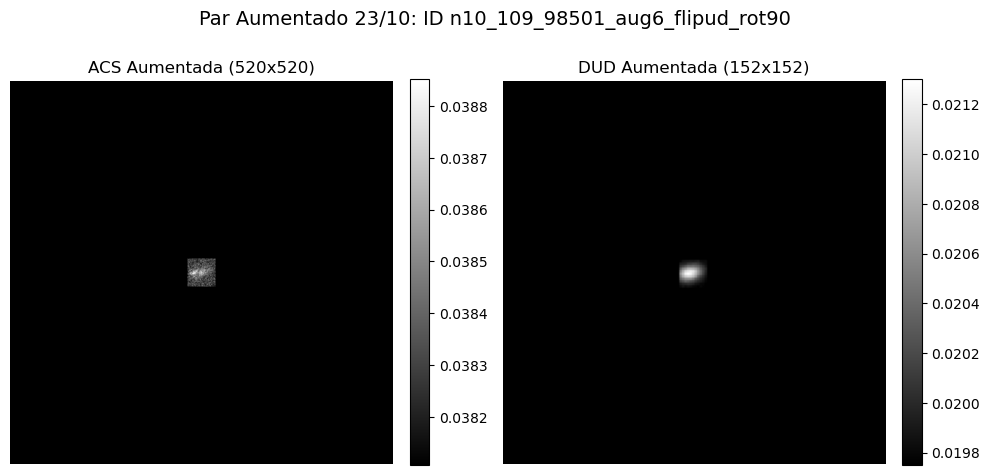

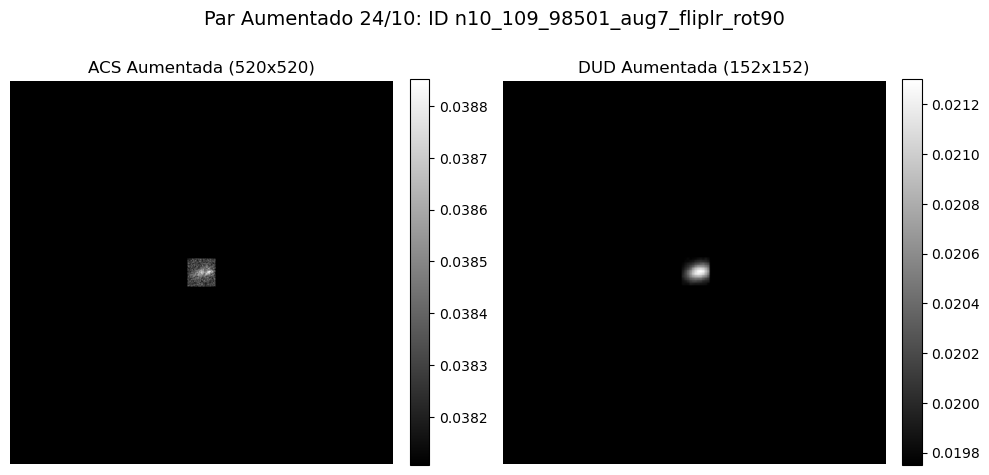

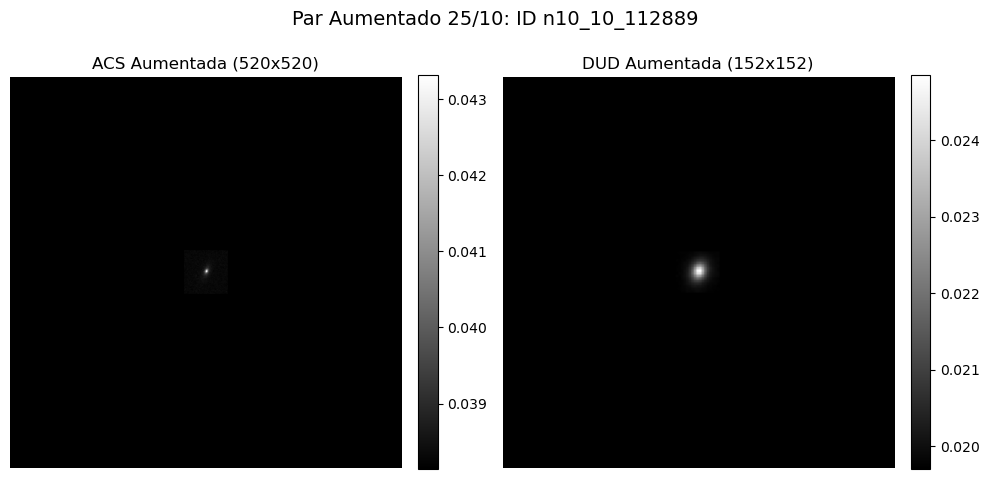

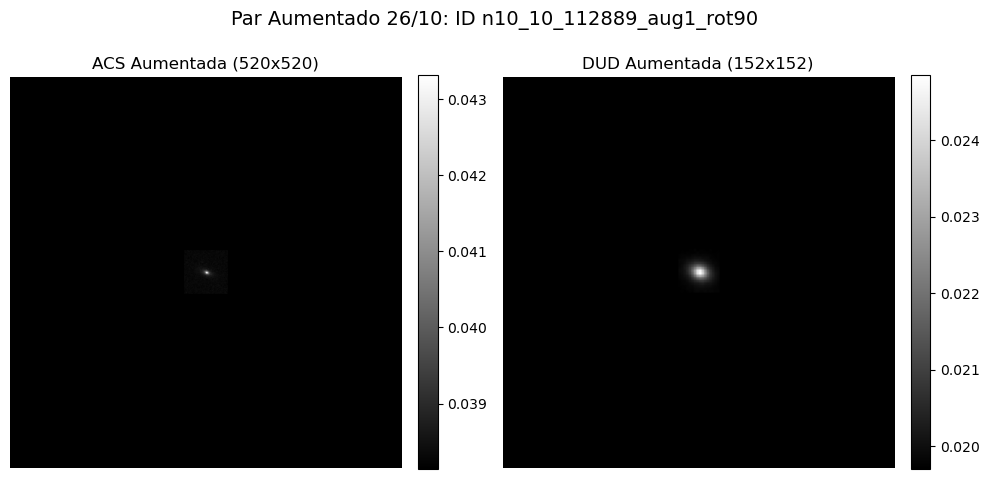

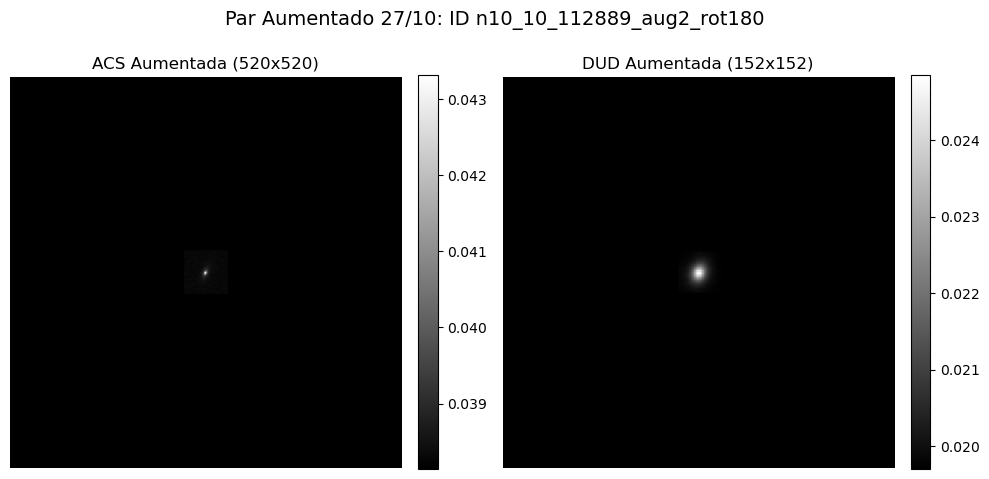

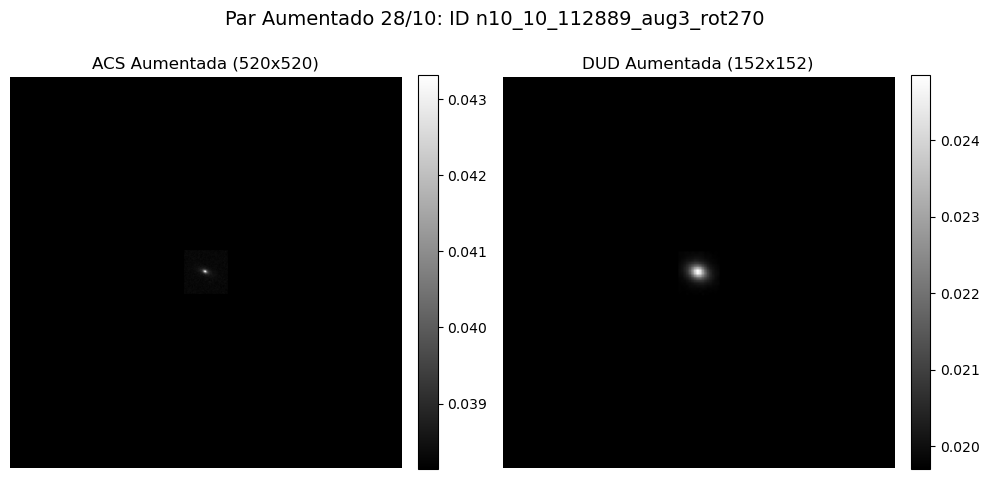

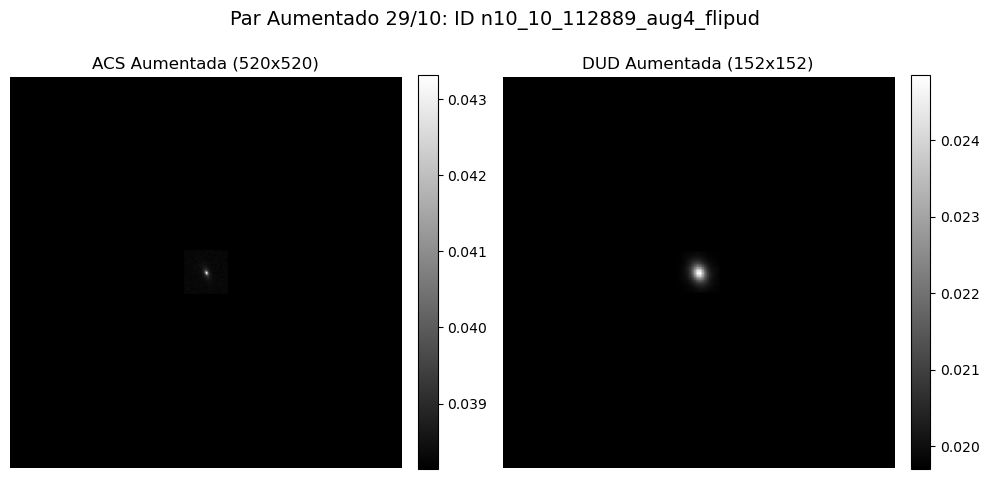

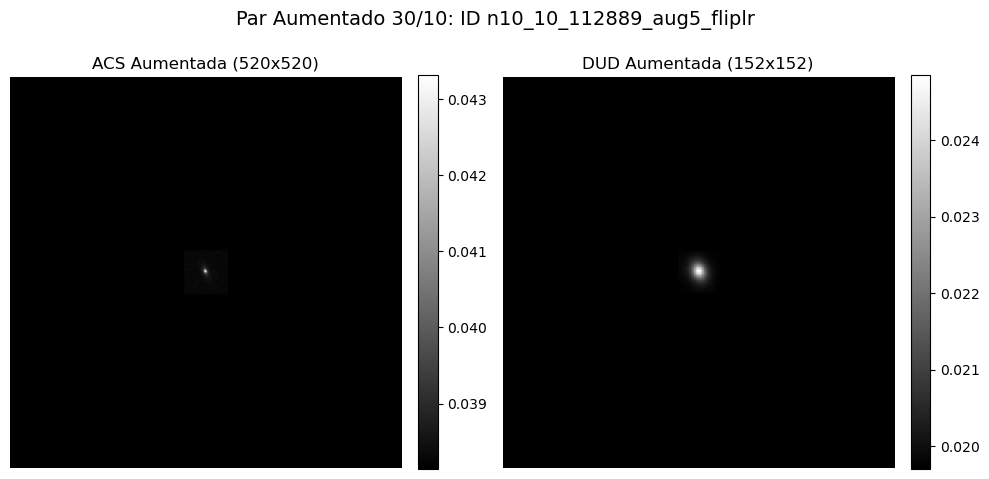

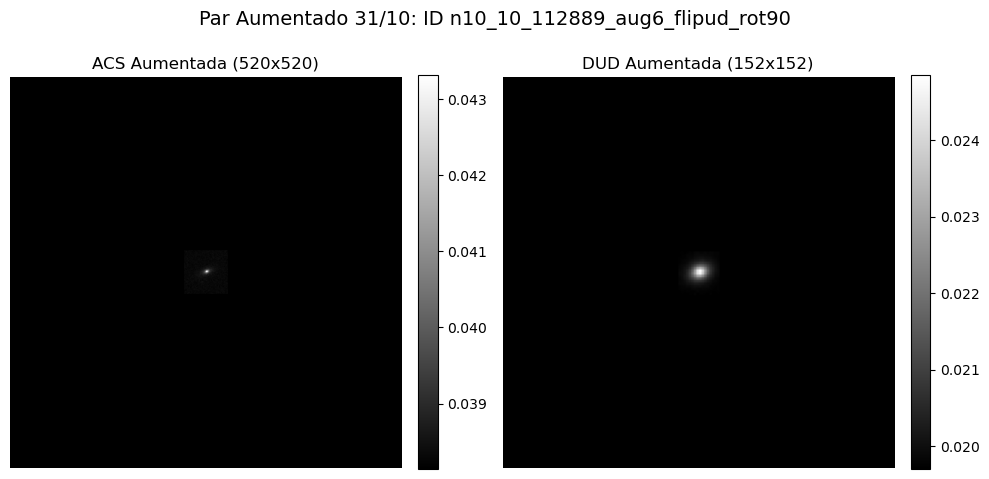

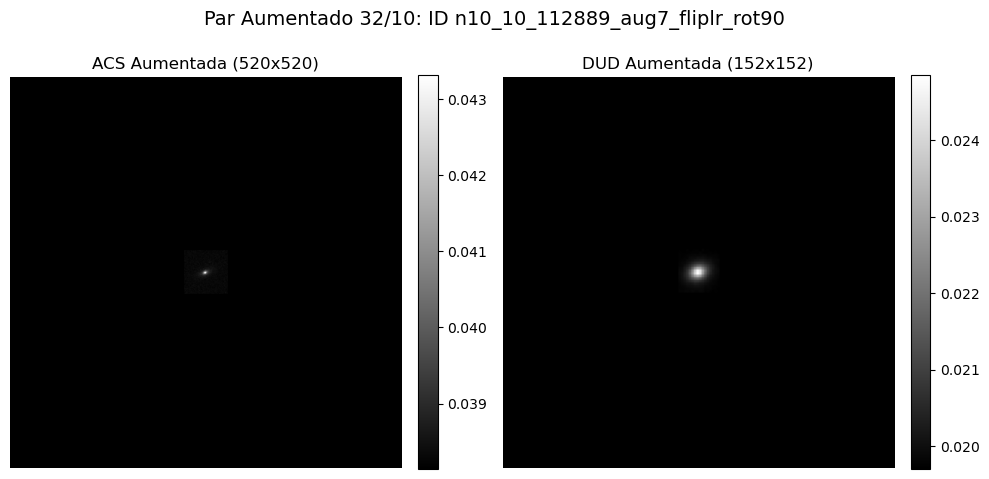

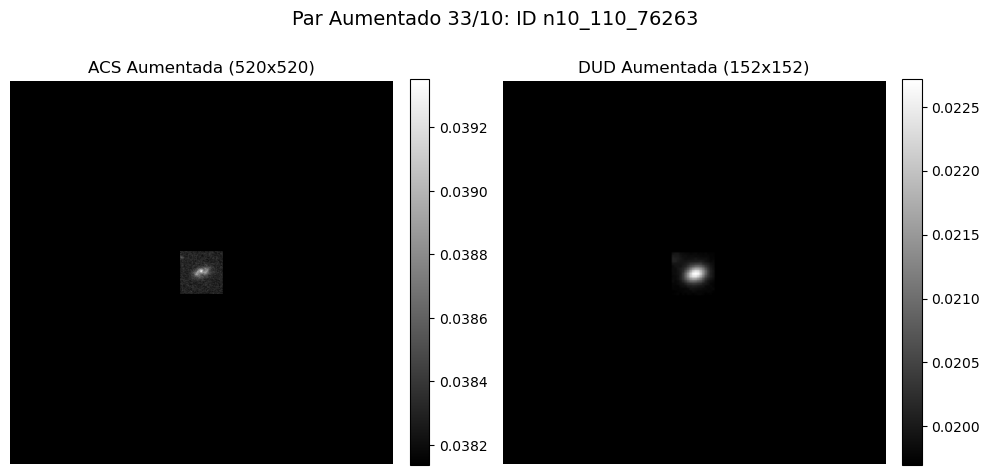

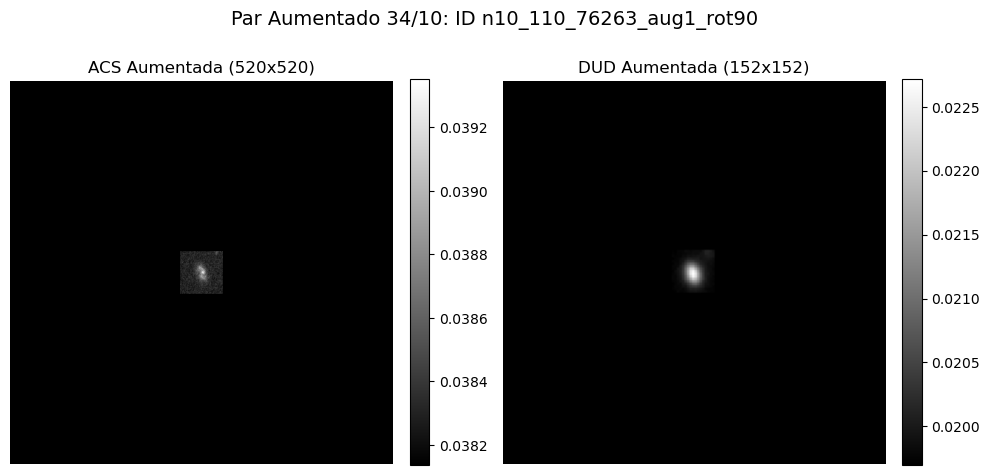

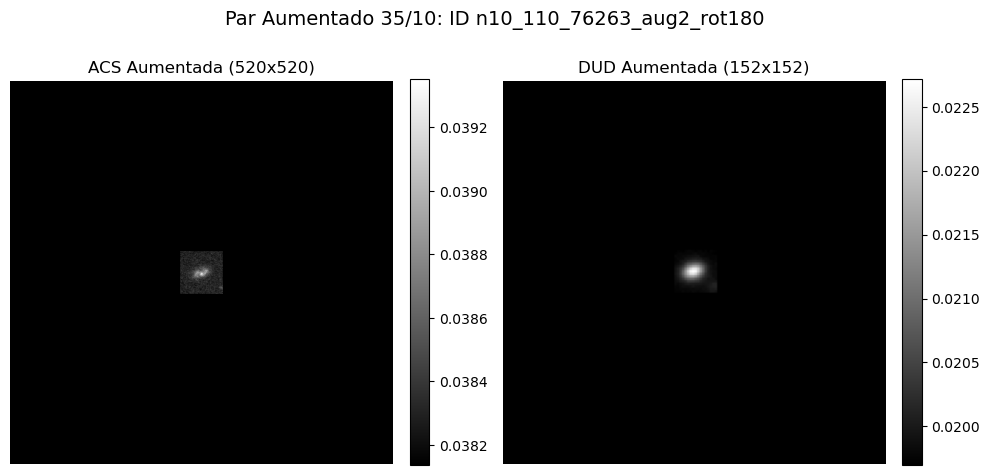

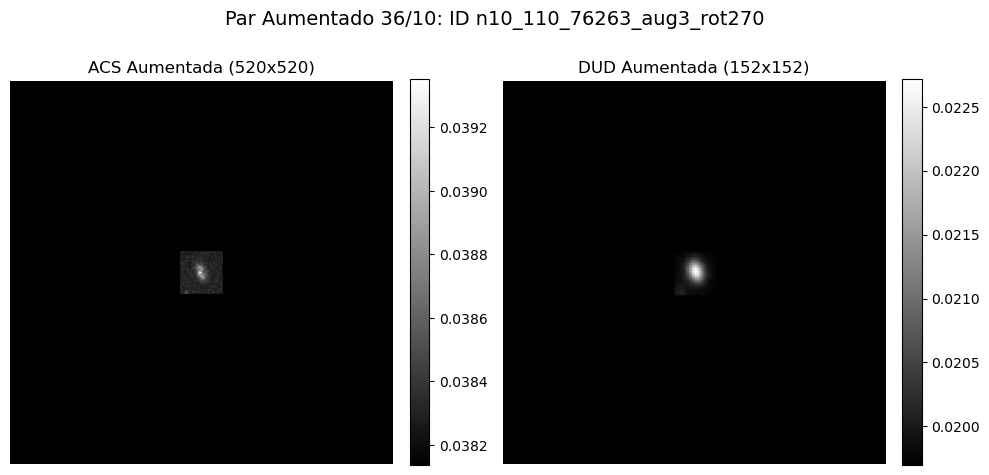

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Ya no necesitamos 'random' para seleccionar las primeras N

# --- Directorios de tus datos aumentados ---
augmented_dud_dir = "../data/Augmentation/dud/"
augmented_acs_dir = "../data/Augmentation/acs/"

def visualize_first_n_augmented_pairs(num_samples=10):
    """
    Selecciona y visualiza las N primeras pares de imágenes aumentadas (ACS y DUD).
    Ajusta el contraste para una mejor visualización de datos normalizados con padding.

    Args:
        num_samples (int): Número de pares de imágenes a visualizar.
    """
    # Obtener la lista de todos los archivos .npy en el directorio ACS aumentado
    # Se ordenan para asegurar que "las 10 primeras" son consistentes en cada ejecución
    acs_files = sorted([f for f in os.listdir(augmented_acs_dir) if f.endswith(".npy")])

    if not acs_files:
        print(f"No se encontraron archivos .npy en el directorio ACS aumentado: {augmented_acs_dir}")
        return

    # Seleccionar las 'num_samples' primeros archivos de ACS
    # Asegurarse de no pedir más muestras de las que hay disponibles
    samples_to_plot = min(num_samples, len(acs_files))
    selected_acs_files = acs_files[64:100] # Tomamos las 10 imágenes después de las 20 primeras

    print(f"\nVisualizando las {samples_to_plot} pares de imágenes aumentadas (después de las 20 primeras)...")

    for i, acs_filename in enumerate(selected_acs_files):
        base_name = acs_filename.replace(".npy", "")
        dud_filename = base_name + ".npy" # Asumimos que los nombres de los pares coinciden

        acs_filepath = os.path.join(augmented_acs_dir, acs_filename)
        dud_filepath = os.path.join(augmented_dud_dir, dud_filename)

        if not os.path.exists(dud_filepath):
            print(f"Advertencia: No se encontró la pareja DUD para {acs_filename}. Saltando este par.")
            continue

        try:
            acs_image = np.load(acs_filepath)
            dud_image = np.load(dud_filepath)

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            fig.suptitle(f'Par Aumentado {i+1}/{samples_to_plot}: ID {base_name}', fontsize=14)

            # --- Lógica de ajuste de vmin/vmax para ACS ---
            acs_min_val = np.min(acs_image[acs_image > 0]) if np.any(acs_image > 0) else 0
            acs_max_val = np.max(acs_image)

            # Mostrar imagen ACS
            ax1 = axes[0]
            im1 = ax1.imshow(acs_image, cmap='gray', origin='lower', vmin=acs_min_val, vmax=acs_max_val)
            fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
            ax1.set_title(f'ACS Aumentada ({acs_image.shape[0]}x{acs_image.shape[1]})')
            ax1.axis('off')

            # --- Lógica de ajuste de vmin/vmax para DUD ---
            dud_min_val = np.min(dud_image[dud_image > 0]) if np.any(dud_image > 0) else 0
            dud_max_val = np.max(dud_image)

            # Mostrar imagen DUD
            ax2 = axes[1]
            im2 = ax2.imshow(dud_image, cmap='gray', origin='lower', vmin=dud_min_val, vmax=dud_max_val)
            fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
            ax2.set_title(f'DUD Aumentada ({dud_image.shape[0]}x{dud_image.shape[1]})')
            ax2.axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

        except Exception as e:
            print(f"Error al cargar o mostrar el par {acs_filename} y {dud_filename}: {e}")

# --- Ejecución ---
visualize_first_n_augmented_pairs(num_samples=10)